## GPT Version

In [1]:
# If running in a clean environment, install minimal deps once.
import importlib, sys, subprocess

def _ensure(pkg, pip_name=None):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or pkg, "-q"])

# Hard requirements
_ensure("pandas")
_ensure("numpy")
_ensure("yfinance", "yfinance>=0.2.43")  # recent fixes
_ensure("pyarrow")
_ensure("tqdm")

import os
import time
import math
from datetime import date, datetime, timedelta, timezone
from typing import List, Optional, Tuple, Iterable, Dict

import numpy as np
import pandas as pd
import yfinance as yf
from tqdm import tqdm

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 50)

# Folders
BASE_DIR = os.path.abspath("./data")
RAW_DIR = os.path.join(BASE_DIR, "raw")
SAMPLE_DIR = os.path.join(BASE_DIR, "samples")
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

print(f"Data base directory: {BASE_DIR}")

Data base directory: c:\Users\alber\trader\notebooks\data


In [2]:
# --- Global Config (override here as needed) ---
START_DATE = "2015-01-01"
END_DATE = date.today().isoformat()  # no lookahead

UNIVERSE = "all_us"   # "sp500" | "custom"
CUSTOM_LIST = None   # e.g., ["AAPL","MSFT","NVDA","AMZN","GOOGL"]

MAX_SYMBOLS = 5000
CACHE_DIR = RAW_DIR
FORCE_REFRESH = False

# Downloads
CHUNK_SIZE = 25                 # symbols per yf.download call
DL_RETRIES = 3                  # retries per networked op
DL_BACKOFF_BASE_SEC = 1.0       # 1s, 2s, 4s...
POLITE_SLEEP_BETWEEN_ACTIONS = 0.15  # seconds between per-symbol actions fetch

# Dtypes expectation for per-symbol parquet
REQUIRED_COLS = ["date", "symbol", "open", "high", "low", "close", "adj_close", "volume", "dividends", "splits"]


In [3]:
# --- Config (update) ---
UNIVERSE = "us_all"   # "sp500" (default) | "us_all" | "custom"
MAX_SYMBOLS = 5000    # bump this if you want near Russell-3000 scale (runtime ↑)

# --------- Universe Retrieval (resilient + progress) ---------
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
import io

# Make sure CUSTOM_LIST exists somewhere in your Config:
try:
    CUSTOM_LIST
except NameError:
    CUSTOM_LIST = None

def normalize_ticker(sym: str) -> str:
    return sym.strip().upper().replace(".", "-").replace(" ", "")

import re

_PREFERRED_PAT = re.compile(r"-P([A-Z])?$")        # e.g., JPM-PA, JPM-PB
_WARRANT_PAT   = re.compile(r"(-)?W(T|S)?$")       # -W, -WT, -WS or …W/WT/WS
_UNIT_PAT      = re.compile(r"(-)?U$")             # -U or …U
_RIGHT_PAT     = re.compile(r"(-)?R$")             # -R or …R

def _rough_equity_filter(t: str) -> bool:
    """
    Keep common equities and common share classes like -A/-B (e.g., BRK-B, BF-B).
    Drop obvious non-equity/warrants/units/rights/preferred, and anything with '+'.
    """
    if not t:
        return False
    if t.startswith("^"):           # indices
        return False
    if "+" in t or "/" in t or "=" in t:  # odd composites / warrants from NASDAQ format
        return False
    # kill warrants/units/rights even without a dash (AACIW, AACT+, AAACU, AACBR)
    if _WARRANT_PAT.search(t) or _UNIT_PAT.search(t) or _RIGHT_PAT.search(t):
        return False
    # preferred shares (keep -A/-B etc., but drop -P, -PA etc.)
    if _PREFERRED_PAT.search(t):
        return False
    return True

def _read_pipe_csv(url: str, tries: int = 3, base_wait: float = 1.0, timeout: int = 15) -> pd.DataFrame:
    """
    Download a pipe-delimited text (|) into a DataFrame using urllib (custom UA) + retry.
    """
    last_err = None
    for k in range(tries):
        try:
            req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
            with urlopen(req, timeout=timeout) as resp:
                text = resp.read().decode("utf-8", errors="ignore")
            return pd.read_csv(io.StringIO(text), sep="|", dtype=str)
        except Exception as e:
            last_err = e
            wait = base_wait * (2 ** k)
            print(f"  fetch fail [{url}] attempt {k+1}/{tries}: {e} -> retrying in {wait:.1f}s")
            time.sleep(wait)
    raise last_err

def _load_nasdaq_trader_symbols() -> pd.DataFrame:
    """
    Load U.S.-listed symbols from NASDAQ Trader:
      - nasdaqlisted.txt (NASDAQ)
      - otherlisted.txt  (NYSE/Arca/American & others)
    Returns: DataFrame ['symbol'] (deduped, filtered).
    """
    # Multiple mirrors for each file to avoid network blocks
    url_sets = [
        ("nasdaqlisted", [
            "https://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt",
            "https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt",
            "http://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt",
            "ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqlisted.txt",
        ]),
        ("otherlisted", [
            "https://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt",
            "https://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt",
            "http://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt",
            "ftp://ftp.nasdaqtrader.com/symboldirectory/otherlisted.txt",
        ]),
    ]

    frames = []
    for name, mirrors in tqdm(url_sets, desc="Loading NASDAQ Trader lists"):
        df = None
        last_err = None
        # try mirrors in order
        for u in mirrors:
            try:
                df = _read_pipe_csv(u, tries=3, base_wait=1.0, timeout=15)
                break
            except Exception as e:
                last_err = e
        if df is None:
            print(f"Warning: failed all mirrors for {name}: {last_err}")
            continue

        # Drop trailing footer like 'File Creation Time'
        first_col = df.columns[0]
        df = df[~df[first_col].astype(str).str.contains("File Creation Time", na=False)]

        # Choose the most compatible symbol column available
        sym_col = None
        for c in ["Symbol", "NASDAQ Symbol", "ACT Symbol", "CQS Symbol"]:
            if c in df.columns:
                sym_col = c
                break
        if sym_col is None:
            continue

        # Filters (if columns exist)
        if "Test Issue" in df.columns:
            df = df[df["Test Issue"] != "Y"]
        if "ETF" in df.columns:
            df = df[df["ETF"] != "Y"]
        if "NextShares" in df.columns:
            df = df[df["NextShares"] != "Y"]

        df = df[df[sym_col].notna() & (df[sym_col].astype(str).str.len() > 0)]
        df = df.rename(columns={sym_col: "symbol"})[["symbol"]]
        frames.append(df)

    if not frames:
        # Network completely blocked -> graceful fallback path
        print("All NASDAQ Trader sources unreachable. Falling back to S&P 500 (then a static basket).")
        try:
            sp = yf.tickers_sp500()
            sp = [normalize_ticker(s) for s in sp]
            return pd.DataFrame({"symbol": sp})
        except Exception:
            # Big, diversified static list (blue chips across sectors)
            fallback = [
                "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","BRK.B","V","JPM","UNH","XOM","LLY","WMT",
                "PG","MA","AVGO","HD","KO","PEP","ABBV","COST","PFE","MRK","CSCO","ADBE","TMO","ABT","CMCSA",
                "CRM","NFLX","NKE","INTC","QCOM","TXN","LIN","ORCL","IBM","CVX","AMD","CAT","GE","UNP","HON",
                "UPS","LOW","MS","GS","BA","SPGI","AMAT","INTU","NOW","DE","ELV","BX","BKNG","ISRG","MDT","PLD",
                "LMT","ADP","SCHW","AMGN","MU","VRTX","REGN","FCX","CVS","GILD","DHR","TJX","BLK","T","MO","SO",
                "DUK","NEE","PGR","USB","PNC","C","AXP","BK","AIG","MMC","CI","ETN","PH","NSC","CSX","FDX","GM",
            ]
            return pd.DataFrame({"symbol": [normalize_ticker(s) for s in fallback]})

    all_syms = pd.concat(frames, ignore_index=True)
    all_syms["symbol"] = all_syms["symbol"].map(normalize_ticker)
    all_syms = all_syms.dropna().drop_duplicates()
    all_syms = all_syms[all_syms["symbol"].map(_rough_equity_filter)]
    return all_syms.reset_index(drop=True)

def get_universe(universe: str, max_symbols: int, custom_list: Optional[List[str]] = None) -> List[str]:
    """
    - 'sp500': fast Wikipedia scrape via yfinance.tickers_sp500()
    - 'us_all': broad U.S. listings from NASDAQ Trader (NASDAQ + NYSE/Arca/American), with robust fallbacks
    - 'custom': your list
    """
    if universe.lower() == "sp500":
        try:
            syms = yf.tickers_sp500()
        except Exception as e:
            print(f"Warning: S&P 500 fetch failed ({e}); falling back to a small default set.")
            syms = ["AAPL","MSFT","NVDA","AMZN","GOOGL","META","BRK.B","V","JPM"]
        syms = sorted({normalize_ticker(s) for s in syms})

    elif universe.lower() == "us_all":
        df = _load_nasdaq_trader_symbols()
        syms = df["symbol"].tolist()

    else:  # 'custom'
        if not custom_list:
            custom_list = ["AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","BRK.B","V","JPM"]
        syms = [normalize_ticker(s) for s in custom_list]

    if max_symbols and max_symbols > 0:
        syms = syms[:max_symbols]
    return syms


In [4]:
def retry(fn, *, tries: int = DL_RETRIES, base_wait: float = DL_BACKOFF_BASE_SEC, exc_types=(Exception,), verbose=True, **fn_kwargs):
    """
    Lightweight retry helper with exponential backoff.
    """
    last_err = None
    for k in range(tries):
        try:
            return fn(**fn_kwargs)
        except exc_types as e:
            last_err = e
            if verbose:
                print(f"{fn.__name__} failed (attempt {k+1}/{tries}): {e}. Backing off {base_wait * (2**k):.1f}s")
            time.sleep(base_wait * (2**k))
    if last_err:
        raise last_err

def chunked(iterable: List[str], n: int) -> Iterable[List[str]]:
    """
    Yield successive n-sized chunks from a list.
    """
    n = max(1, int(n))
    for i in range(0, len(iterable), n):
        yield iterable[i : i + n]


In [5]:
def _normalize_multi_ticker_df(df: pd.DataFrame, symbols: List[str], *, auto_adjust: bool) -> pd.DataFrame:
    """
    Normalize yf.download multi-ticker result to tidy DataFrame:
    Columns exactly: date, symbol, open, high, low, close, adj_close, volume
    
    - If auto_adjust=False: df contains raw O/H/L/C + Adj Close and Volume.
    - If auto_adjust=True : df contains adjusted O/H/L/C (Close is adjusted) + Volume; we will later merge raw close separately.
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=["date","symbol","open","high","low","close","adj_close","volume"])

    frames = []
    if isinstance(df.columns, pd.MultiIndex):
        # We expect first level to be price field or ticker depending on group_by. We request group_by='ticker',
        # so first level is ticker.
        level0 = df.columns.get_level_values(0)
        first_is_ticker = all(l in symbols for l in set(level0))
        if first_is_ticker:
            for sym in symbols:
                if sym not in df.columns.get_level_values(0):
                    continue
                sub = df[sym].copy()
                # Normalize column names
                cols = {c: c for c in sub.columns}
                cols = {c: c.lower().replace(" ", "_") for c in cols}
                sub = sub.rename(columns=cols)
                # Standardize to required columns
                # auto_adjust=False: expect 'adj_close'; True: no adj_close -> will fill later
                row = pd.DataFrame({
                    "date": sub.index.values,
                    "symbol": sym,
                    "open": sub.get("open"),
                    "high": sub.get("high"),
                    "low": sub.get("low"),
                    "close": sub.get("close"),          # may be raw or adjusted depending on auto_adjust
                    "adj_close": sub.get("adj_close"),  # may be None if auto_adjust=True
                    "volume": sub.get("volume"),
                })
                frames.append(row)
        else:
            # Alternative shape (fields first). Handle defensively.
            # df.columns = (field, ticker)
            for sym in symbols:
                cols = {}
                for field in ["Open","High","Low","Close","Adj Close","Volume"]:
                    if (field, sym) in df.columns:
                        cols[field] = df[(field, sym)]
                if not cols:
                    continue
                sub = pd.DataFrame(cols, index=df.index)
                sub.columns = [c.lower().replace(" ", "_") for c in sub.columns]
                row = pd.DataFrame({
                    "date": sub.index.values,
                    "symbol": sym,
                    "open": sub.get("open"),
                    "high": sub.get("high"),
                    "low": sub.get("low"),
                    "close": sub.get("close"),
                    "adj_close": sub.get("adj_close"),
                    "volume": sub.get("volume"),
                })
                frames.append(row)
    else:
        # Single ticker case
        sub = df.copy()
        cols = {c: c.lower().replace(" ", "_") for c in sub.columns}
        sub = sub.rename(columns=cols)
        sym = symbols[0] if symbols else "UNKNOWN"
        row = pd.DataFrame({
            "date": sub.index.values,
            "symbol": sym,
            "open": sub.get("open"),
            "high": sub.get("high"),
            "low": sub.get("low"),
            "close": sub.get("close"),
            "adj_close": sub.get("adj_close"),
            "volume": sub.get("volume"),
        })
        frames.append(row)

    out = pd.concat(frames, axis=0, ignore_index=True) if frames else pd.DataFrame(columns=["date","symbol","open","high","low","close","adj_close","volume"])
    # Ensure types
    out["date"] = pd.to_datetime(out["date"], utc=False)
    num_cols = ["open","high","low","close","adj_close","volume"]
    for c in num_cols:
        if c not in out.columns:
            out[c] = np.nan
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out


def download_ohlcv(symbols: List[str], start: str, end: str, *, auto_adjust: bool = False, silent=False) -> pd.DataFrame:
    """
    Use yf.download(...) to retrieve OHLCV for a batch of symbols and return tidy frame.
    - If auto_adjust=False (default): we receive raw O/H/L/C + Adj Close. (Recommended for Stage 1.)
    - If auto_adjust=True: yf returns adjusted O/H/L/C, no 'Adj Close'; we will merge raw Close separately.
    """
    if not symbols:
        return pd.DataFrame(columns=["date","symbol","open","high","low","close","adj_close","volume"])

    def _call():
        return yf.download(
            tickers=symbols,
            start=start,
            end=end,
            auto_adjust=auto_adjust,
            group_by="ticker",
            threads=True,
            actions=False,
            progress=False,
        )

    df_raw = retry(_call, tries=DL_RETRIES, base_wait=DL_BACKOFF_BASE_SEC, verbose=not silent)
    tidy = _normalize_multi_ticker_df(df_raw, symbols, auto_adjust=auto_adjust)

    if auto_adjust:
        # Fetch raw Close once and merge it as 'close' (while adjusted 'Close' already sits in tidy['close'])
        def _call_rawclose():
            df_close = yf.download(
                tickers=symbols,
                start=start,
                end=end,
                auto_adjust=False,
                group_by="ticker",
                threads=True,
                actions=False,
                progress=False,
            )
            return df_close

        df_close = retry(_call_rawclose, tries=DL_RETRIES, base_wait=DL_BACKOFF_BASE_SEC, verbose=not silent)
        # Extract 'Close' into long
        close_long = []
        if isinstance(df_close.columns, pd.MultiIndex):
            level0 = df_close.columns.get_level_values(0)
            first_is_ticker = all(l in symbols for l in set(level0))
            if first_is_ticker:
                for sym in symbols:
                    if sym in df_close.columns.get_level_values(0):
                        s = df_close[sym].get("Close")
                        if s is not None and not s.empty:
                            tmp = pd.DataFrame({"date": s.index, "symbol": sym, "close_raw": s.values})
                            close_long.append(tmp)
            else:
                # fields first
                for sym in symbols:
                    key = ("Close", sym)
                    if key in df_close.columns:
                        s = df_close[key]
                        tmp = pd.DataFrame({"date": s.index, "symbol": sym, "close_raw": s.values})
                        close_long.append(tmp)
        else:
            # Single ticker
            s = df_close.get("Close")
            if s is not None:
                tmp = pd.DataFrame({"date": s.index, "symbol": symbols[0], "close_raw": s.values})
                close_long.append(tmp)
        if close_long:
            close_long = pd.concat(close_long, ignore_index=True)
            close_long["date"] = pd.to_datetime(close_long["date"])
            tidy = tidy.merge(close_long, on=["date","symbol"], how="left")
            # Adjusted close is in tidy['close'], raw close is in 'close_raw'.
            tidy = tidy.rename(columns={"close": "adj_close", "close_raw": "close"})
        else:
            # If we couldn't fetch raw close, at least ensure schema
            tidy = tidy.rename(columns={"close": "adj_close"})
            tidy["close"] = np.nan

    # Reorder columns
    tidy = tidy[["date","symbol","open","high","low","close","adj_close","volume"]]
    return tidy


In [6]:
def _normalize_multi_ticker_df(df: pd.DataFrame, symbols: List[str], *, auto_adjust: bool) -> pd.DataFrame:
    """
    Normalize yf.download multi-ticker result to tidy DataFrame:
    Columns exactly: date, symbol, open, high, low, close, adj_close, volume
    
    - If auto_adjust=False: df contains raw O/H/L/C + Adj Close and Volume.
    - If auto_adjust=True : df contains adjusted O/H/L/C (Close is adjusted) + Volume; we will later merge raw close separately.
    """
    if df is None or df.empty:
        return pd.DataFrame(columns=["date","symbol","open","high","low","close","adj_close","volume"])

    frames = []
    if isinstance(df.columns, pd.MultiIndex):
        # We expect first level to be price field or ticker depending on group_by. We request group_by='ticker',
        # so first level is ticker.
        level0 = df.columns.get_level_values(0)
        first_is_ticker = all(l in symbols for l in set(level0))
        if first_is_ticker:
            for sym in symbols:
                if sym not in df.columns.get_level_values(0):
                    continue
                sub = df[sym].copy()
                # Normalize column names
                cols = {c: c for c in sub.columns}
                cols = {c: c.lower().replace(" ", "_") for c in cols}
                sub = sub.rename(columns=cols)
                # Standardize to required columns
                # auto_adjust=False: expect 'adj_close'; True: no adj_close -> will fill later
                row = pd.DataFrame({
                    "date": sub.index.values,
                    "symbol": sym,
                    "open": sub.get("open"),
                    "high": sub.get("high"),
                    "low": sub.get("low"),
                    "close": sub.get("close"),          # may be raw or adjusted depending on auto_adjust
                    "adj_close": sub.get("adj_close"),  # may be None if auto_adjust=True
                    "volume": sub.get("volume"),
                })
                frames.append(row)
        else:
            # Alternative shape (fields first). Handle defensively.
            # df.columns = (field, ticker)
            for sym in symbols:
                cols = {}
                for field in ["Open","High","Low","Close","Adj Close","Volume"]:
                    if (field, sym) in df.columns:
                        cols[field] = df[(field, sym)]
                if not cols:
                    continue
                sub = pd.DataFrame(cols, index=df.index)
                sub.columns = [c.lower().replace(" ", "_") for c in sub.columns]
                row = pd.DataFrame({
                    "date": sub.index.values,
                    "symbol": sym,
                    "open": sub.get("open"),
                    "high": sub.get("high"),
                    "low": sub.get("low"),
                    "close": sub.get("close"),
                    "adj_close": sub.get("adj_close"),
                    "volume": sub.get("volume"),
                })
                frames.append(row)
    else:
        # Single ticker case
        sub = df.copy()
        cols = {c: c.lower().replace(" ", "_") for c in sub.columns}
        sub = sub.rename(columns=cols)
        sym = symbols[0] if symbols else "UNKNOWN"
        row = pd.DataFrame({
            "date": sub.index.values,
            "symbol": sym,
            "open": sub.get("open"),
            "high": sub.get("high"),
            "low": sub.get("low"),
            "close": sub.get("close"),
            "adj_close": sub.get("adj_close"),
            "volume": sub.get("volume"),
        })
        frames.append(row)

    out = pd.concat(frames, axis=0, ignore_index=True) if frames else pd.DataFrame(columns=["date","symbol","open","high","low","close","adj_close","volume"])
    # Ensure types
    out["date"] = pd.to_datetime(out["date"], utc=False)
    num_cols = ["open","high","low","close","adj_close","volume"]
    for c in num_cols:
        if c not in out.columns:
            out[c] = np.nan
        out[c] = pd.to_numeric(out[c], errors="coerce")
    return out


def download_ohlcv(symbols: List[str], start: str, end: str, *, auto_adjust: bool = False, silent=False) -> pd.DataFrame:
    """
    Use yf.download(...) to retrieve OHLCV for a batch of symbols and return tidy frame.
    - If auto_adjust=False (default): we receive raw O/H/L/C + Adj Close. (Recommended for Stage 1.)
    - If auto_adjust=True: yf returns adjusted O/H/L/C, no 'Adj Close'; we will merge raw Close separately.
    """
    if not symbols:
        return pd.DataFrame(columns=["date","symbol","open","high","low","close","adj_close","volume"])

    def _call():
        return yf.download(
            tickers=symbols,
            start=start,
            end=end,
            auto_adjust=auto_adjust,
            group_by="ticker",
            threads=True,
            actions=False,
            progress=False,
        )

    df_raw = retry(_call, tries=DL_RETRIES, base_wait=DL_BACKOFF_BASE_SEC, verbose=not silent)
    tidy = _normalize_multi_ticker_df(df_raw, symbols, auto_adjust=auto_adjust)

    if auto_adjust:
        # Fetch raw Close once and merge it as 'close' (while adjusted 'Close' already sits in tidy['close'])
        def _call_rawclose():
            df_close = yf.download(
                tickers=symbols,
                start=start,
                end=end,
                auto_adjust=False,
                group_by="ticker",
                threads=True,
                actions=False,
                progress=False,
            )
            return df_close

        df_close = retry(_call_rawclose, tries=DL_RETRIES, base_wait=DL_BACKOFF_BASE_SEC, verbose=not silent)
        # Extract 'Close' into long
        close_long = []
        if isinstance(df_close.columns, pd.MultiIndex):
            level0 = df_close.columns.get_level_values(0)
            first_is_ticker = all(l in symbols for l in set(level0))
            if first_is_ticker:
                for sym in symbols:
                    if sym in df_close.columns.get_level_values(0):
                        s = df_close[sym].get("Close")
                        if s is not None and not s.empty:
                            tmp = pd.DataFrame({"date": s.index, "symbol": sym, "close_raw": s.values})
                            close_long.append(tmp)
            else:
                # fields first
                for sym in symbols:
                    key = ("Close", sym)
                    if key in df_close.columns:
                        s = df_close[key]
                        tmp = pd.DataFrame({"date": s.index, "symbol": sym, "close_raw": s.values})
                        close_long.append(tmp)
        else:
            # Single ticker
            s = df_close.get("Close")
            if s is not None:
                tmp = pd.DataFrame({"date": s.index, "symbol": symbols[0], "close_raw": s.values})
                close_long.append(tmp)
        if close_long:
            close_long = pd.concat(close_long, ignore_index=True)
            close_long["date"] = pd.to_datetime(close_long["date"])
            tidy = tidy.merge(close_long, on=["date","symbol"], how="left")
            # Adjusted close is in tidy['close'], raw close is in 'close_raw'.
            tidy = tidy.rename(columns={"close": "adj_close", "close_raw": "close"})
        else:
            # If we couldn't fetch raw close, at least ensure schema
            tidy = tidy.rename(columns={"close": "adj_close"})
            tidy["close"] = np.nan

    # Reorder columns
    tidy = tidy[["date","symbol","open","high","low","close","adj_close","volume"]]
    return tidy


In [7]:
def fetch_actions_for_symbol(symbol: str, start: str, end: str) -> pd.DataFrame:
    """
    Fetch dividends and splits for a single symbol and return tidy actions frame:
    columns: date, symbol, dividends (float, default 0), splits (float, default 1)
    """
    def _call_actions():
        tk = yf.Ticker(symbol)
        # More efficient to pull .dividends / .splits separately
        div = tk.dividends
        spl = tk.splits
        return div, spl

    try:
        div, spl = retry(_call_actions, tries=DL_RETRIES, base_wait=DL_BACKOFF_BASE_SEC, verbose=False)
    except Exception as e:
        print(f"Actions fetch failed for {symbol}: {e}")
        div, spl = pd.Series(dtype=float), pd.Series(dtype=float)

    # Clip to [start,end)
    start_ts = pd.to_datetime(start)
    end_ts = pd.to_datetime(end)
    if not div.empty:
        div = div[(div.index >= start_ts) & (div.index <= end_ts)]
    if not spl.empty:
        spl = spl[(spl.index >= start_ts) & (spl.index <= end_ts)]

    df = pd.DataFrame({"date": [], "symbol": [], "dividends": [], "splits": []})
    if not div.empty or not spl.empty:
        df = pd.DataFrame({"date": pd.Index([], dtype="datetime64[ns]")})
        if not div.empty:
            df = pd.merge(df, div.rename("dividends").to_frame(), left_on="date", right_index=True, how="outer")
        else:
            df["dividends"] = np.nan
        if not spl.empty:
            df = pd.merge(df, spl.rename("splits").to_frame(), left_on="date", right_index=True, how="outer")
        else:
            df["splits"] = np.nan

    if df.empty:
        df = pd.DataFrame({"date": [], "dividends": [], "splits": []})

    df["date"] = pd.to_datetime(df["date"])
    df["symbol"] = symbol
    # Fill defaults (no action)
    df["dividends"] = pd.to_numeric(df["dividends"], errors="coerce").fillna(0.0).astype(float)
    df["splits"] = pd.to_numeric(df["splits"], errors="coerce").fillna(1.0).astype(float)
    return df[["date","symbol","dividends","splits"]]


In [8]:
def symbol_parquet_path(symbol: str, cache_dir: str = CACHE_DIR) -> str:
    return os.path.join(cache_dir, f"{symbol}.parquet")

def save_symbol_parquet(df_sym: pd.DataFrame, symbol: str, cache_dir: str = CACHE_DIR) -> str:
    """
    Save single-symbol tidy DataFrame to Parquet with enforced schema & sorted by date.
    """
    path = symbol_parquet_path(symbol, cache_dir)
    if df_sym.empty:
        # Write empty with schema
        schema_df = pd.DataFrame(columns=REQUIRED_COLS)
        schema_df.to_parquet(path, engine="pyarrow", index=False)
        return path

    # Schema / dtypes
    df = df_sym.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["symbol"] = symbol
    for col in ["open","high","low","close","adj_close","dividends","splits","volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    # sort and drop dups
    df = df.sort_values("date").drop_duplicates(subset=["symbol","date"], keep="last")
    # enforce columns (and order)
    for c in REQUIRED_COLS:
        if c not in df.columns:
            df[c] = np.nan if c not in ["splits"] else 1.0
    df = df[REQUIRED_COLS]
    df.to_parquet(path, engine="pyarrow", index=False)
    return path

def load_symbol_parquet_if_usable(symbol: str, start: str, end: str, cache_dir: str = CACHE_DIR) -> Optional[pd.DataFrame]:
    """
    Load cached Parquet and verify it covers [start, end] date range (min/max date check).
    Returns DataFrame if usable, else None.
    """
    path = symbol_parquet_path(symbol, cache_dir)
    if not os.path.exists(path):
        return None
    try:
        df = pd.read_parquet(path, engine="pyarrow")
    except Exception as e:
        print(f"Cache read failed for {symbol}: {e}")
        return None

    if df.empty:
        return df  # empty is "usable" for idempotency, but may trigger re-download upstream

    df["date"] = pd.to_datetime(df["date"])
    min_d, max_d = df["date"].min(), df["date"].max()
    start_ts, end_ts = pd.to_datetime(start), pd.to_datetime(end)
    covers = (min_d <= start_ts) and (max_d >= end_ts - pd.Timedelta(days=0))
    if covers:
        return df
    return None


In [9]:
def fetch_symbol_batch(symbols: List[str], start: str, end: str, *, auto_adjust: bool = False) -> pd.DataFrame:
    """
    Download OHLCV for a batch of symbols and return tidy OHLCV.
    """
    if not symbols:
        return pd.DataFrame(columns=["date","symbol","open","high","low","close","adj_close","volume"])
    return download_ohlcv(symbols, start, end, auto_adjust=auto_adjust, silent=True)

def fetch_and_cache_symbol(symbol: str, start: str, end: str, *, force_refresh: bool = False, auto_adjust: bool = False) -> Tuple[str, bool]:
    """
    Orchestrate cache check, download (if needed), corporate actions merge, and save.
    Returns (path, downloaded_flag).
    """
    if not force_refresh:
        cached = load_symbol_parquet_if_usable(symbol, start, end, CACHE_DIR)
        if cached is not None:
            # Already cached with required coverage
            return symbol_parquet_path(symbol), False

    # Download OHLCV (single symbol via batch helper for consistency)
    tidy = fetch_symbol_batch([symbol], start, end, auto_adjust=auto_adjust)
    # Merge corporate actions
    actions = fetch_actions_for_symbol(symbol, start, end)
    # Left join on (symbol, date)
    merged = pd.merge(tidy, actions, on=["symbol","date"], how="left")
    merged["dividends"] = pd.to_numeric(merged["dividends"], errors="coerce").fillna(0.0).astype(float)
    merged["splits"] = pd.to_numeric(merged["splits"], errors="coerce").fillna(1.0).astype(float)

    # Save
    p = save_symbol_parquet(merged, symbol, CACHE_DIR)
    time.sleep(POLITE_SLEEP_BETWEEN_ACTIONS)
    return p, True

def batch_fetch_universe(
    symbols: List[str],
    start: str,
    end: str,
    *,
    force_refresh: bool = False,
    auto_adjust: bool = False
) -> Dict[str, str]:
    """
    Loop over universe, fetch/cache per symbol.
    Uses chunked OHLCV downloads for efficiency, merges corporate actions, 
    and saves each symbol's data to Parquet.
    
    Returns:
        dict mapping symbol -> parquet path.
    """
    # Determine which symbols need downloading
    need_syms = []
    ready_syms = []
    for s in symbols:
        if not force_refresh and load_symbol_parquet_if_usable(s, start, end, CACHE_DIR) is not None:
            ready_syms.append(s)
        else:
            need_syms.append(s)

    paths: Dict[str, str] = {s: symbol_parquet_path(s) for s in ready_syms}
    if ready_syms:
        print(f"Skipping {len(ready_syms)} cached symbols.")

    bad_syms = []

    # Download in chunks
    for chunk in tqdm(list(chunked(need_syms, CHUNK_SIZE)), desc="Downloading OHLCV (chunks)"):
        tidy = fetch_symbol_batch(chunk, start, end, auto_adjust=auto_adjust)

        # Per-symbol corporate actions + caching
        for s in tqdm(chunk, desc="Actions + cache (per symbol)", leave=False):
            df_s = tidy[tidy["symbol"] == s].copy()

            # Skip if Yahoo returned no data (delisted/junk)
            if df_s.empty:
                bad_syms.append(s)
                continue

            actions = fetch_actions_for_symbol(s, start, end)
            merged = pd.merge(df_s, actions, on=["symbol", "date"], how="left")
            merged["dividends"] = pd.to_numeric(merged["dividends"], errors="coerce").fillna(0.0).astype(float)
            merged["splits"] = pd.to_numeric(merged["splits"], errors="coerce").fillna(1.0).astype(float)

            p = save_symbol_parquet(merged, s, CACHE_DIR)
            paths[s] = p
            time.sleep(POLITE_SLEEP_BETWEEN_ACTIONS)

    if bad_syms:
        print(f"\nSkipped {len(bad_syms)} symbols with no data. Example: {bad_syms[:10]}")

    return paths



In [10]:
def build_symbol_master(cache_dir: str = CACHE_DIR) -> pd.DataFrame:
    """
    Scan cached Parquets and build symbol master:
    symbol, first_date, last_date, n_bars, is_active (last_date within 14d), has_dividends, has_splits
    """
    rows = []
    files = [f for f in os.listdir(cache_dir) if f.lower().endswith(".parquet")]
    for f in files:
        symbol = f[:-8]  # remove .parquet
        path = os.path.join(cache_dir, f)
        try:
            df = pd.read_parquet(path, engine="pyarrow", columns=["date","dividends","splits"])
        except Exception as e:
            print(f"Failed reading {path}: {e}")
            continue
        if df.empty:
            rows.append({
                "symbol": symbol, "first_date": pd.NaT, "last_date": pd.NaT, "n_bars": 0,
                "is_active": False, "has_dividends": False, "has_splits": False
            })
            continue
        df["date"] = pd.to_datetime(df["date"])
        first_date = df["date"].min()
        last_date = df["date"].max()
        n_bars = df.shape[0]
        has_div = bool(pd.to_numeric(df["dividends"], errors="coerce").fillna(0).gt(0).any())
        has_split = bool(pd.to_numeric(df["splits"], errors="coerce").fillna(1).ne(1).any())
        is_active = bool(last_date >= (pd.Timestamp(date.today()) - pd.Timedelta(days=14)))
        rows.append({
            "symbol": symbol,
            "first_date": first_date,
            "last_date": last_date,
            "n_bars": n_bars,
            "is_active": is_active,
            "has_dividends": has_div,
            "has_splits": has_split,
        })

    master = pd.DataFrame(rows)
    if not master.empty:
        master = master.sort_values("symbol").reset_index(drop=True)
    out_path = os.path.join(BASE_DIR, "symbol_master.parquet")
    master.to_parquet(out_path, engine="pyarrow", index=False)
    print(f"Symbol master saved: {out_path} ({len(master)} rows)")
    return master


In [11]:
def approximate_trading_days(start: str, end: str) -> pd.DatetimeIndex:
    """
    Approximate trading days using business-day frequency (excludes weekends, ignores exchange holidays).
    """
    return pd.date_range(start=pd.to_datetime(start), end=pd.to_datetime(end), freq="B")

def missingness_report_for_symbol(symbol: str, start: str, end: str) -> pd.DataFrame:
    """
    For a single symbol, compute missingness vs business-day calendar within the covered range of the file.
    Returns one-row DataFrame with: symbol, first_date, last_date, n_expected, n_present, n_missing, pct_missing
    """
    path = symbol_parquet_path(symbol)
    if not os.path.exists(path):
        return pd.DataFrame([{
            "symbol": symbol, "first_date": pd.NaT, "last_date": pd.NaT,
            "n_expected": 0, "n_present": 0, "n_missing": 0, "pct_missing": np.nan
        }])
    df = pd.read_parquet(path, engine="pyarrow")
    if df.empty:
        return pd.DataFrame([{
            "symbol": symbol, "first_date": pd.NaT, "last_date": pd.NaT,
            "n_expected": 0, "n_present": 0, "n_missing": 0, "pct_missing": np.nan
        }])
    df["date"] = pd.to_datetime(df["date"])
    first_date = max(pd.to_datetime(start), df["date"].min())
    last_date = min(pd.to_datetime(end), df["date"].max())
    if pd.isna(first_date) or pd.isna(last_date) or first_date > last_date:
        n_expected = n_present = n_missing = 0
        pct_missing = np.nan
    else:
        cal = approximate_trading_days(first_date, last_date)
        present = pd.Index(df["date"].unique())
        n_expected = len(cal)
        n_present = len(present.intersection(cal))
        n_missing = max(0, n_expected - n_present)
        pct_missing = (n_missing / n_expected * 100.0) if n_expected > 0 else 0.0

    return pd.DataFrame([{
        "symbol": symbol,
        "first_date": first_date,
        "last_date": last_date,
        "n_expected": n_expected,
        "n_present": n_present,
        "n_missing": n_missing,
        "pct_missing": round(pct_missing, 3) if not pd.isna(pct_missing) else np.nan
    }])

def find_duplicates_for_symbol(symbol: str) -> int:
    """
    Count duplicate (symbol, date) rows for a symbol's cached parquet.
    """
    path = symbol_parquet_path(symbol)
    if not os.path.exists(path):
        return 0
    df = pd.read_parquet(path, engine="pyarrow", columns=["date","symbol"])
    if df.empty:
        return 0
    df["date"] = pd.to_datetime(df["date"])
    dups = df.duplicated(subset=["symbol","date"]).sum()
    return int(dups)

def global_quality_summary(symbols: List[str], start: str, end: str) -> Tuple[pd.DataFrame, int]:
    """
    Build missingness and duplicate reports across symbols.
    Also check sanity: adj_close non-null rate, volume non-negative (sampled).
    """
    miss_rows = []
    dup_count = 0
    bad_adj_close = 0
    bad_volume = 0
    sampled = 0

    for s in symbols:
        miss_rows.append(missingness_report_for_symbol(s, start, end).iloc[0].to_dict())
        dups = find_duplicates_for_symbol(s)
        dup_count += dups

        # Sanity sampling
        path = symbol_parquet_path(s)
        if os.path.exists(path):
            df = pd.read_parquet(path, engine="pyarrow")
            if not df.empty:
                sampled += 1
                nac = df["adj_close"].isna().mean() if "adj_close" in df.columns else 1.0
                if nac > 0.05:
                    bad_adj_close += 1
                vol_neg = (pd.to_numeric(df["volume"], errors="coerce").fillna(-1) < 0).any()
                if vol_neg:
                    bad_volume += 1

    miss_df = pd.DataFrame(miss_rows).sort_values("pct_missing", ascending=False)
    # Print summaries
    print("\n=== Missingness (Top 10 by % missing versus business-day calendar) ===")
    print(miss_df.head(10)[["symbol","pct_missing","n_missing","n_expected"]].to_string(index=False))
    print(f"\nDuplicate (symbol,date) rows across universe: {dup_count}")
    if sampled > 0:
        print(f"Symbols with >5% adj_close nulls: {bad_adj_close}/{sampled}")
        print(f"Symbols with any negative volume: {bad_volume}/{sampled}")

    return miss_df, dup_count


In [12]:
def ensure_sample_join(symbols: List[str], out_path: str = os.path.join(SAMPLE_DIR, "sample_join.parquet"), n: int = 5) -> str:
    """
    Join first n symbols into a single tidy frame and save to sample parquet.
    """
    pick = [s for s in symbols[:n] if os.path.exists(symbol_parquet_path(s))]
    frames = []
    for s in pick:
        df = pd.read_parquet(symbol_parquet_path(s), engine="pyarrow")
        frames.append(df)
    if frames:
        joined = pd.concat(frames, ignore_index=True).sort_values(["symbol","date"])
        joined.to_parquet(out_path, engine="pyarrow", index=False)
        print(f"Sample join saved: {out_path} (symbols: {pick})")
    else:
        print("No frames to join for sample.")
    return out_path

def validate_acceptance(symbols: List[str]) -> None:
    """
    Acceptance criteria checks and informative assertions.
    """
    # 1) raw files count
    raw_files = [f for f in os.listdir(RAW_DIR) if f.endswith(".parquet")]
    print(f"\nRaw parquet files in {RAW_DIR}: {len(raw_files)}")

    # 2) schema per file (sample check across up to 15 files)
    check_files = raw_files[: min(15, len(raw_files))]
    for f in check_files:
        path = os.path.join(RAW_DIR, f)
        df = pd.read_parquet(path, engine="pyarrow")
        missing_cols = [c for c in REQUIRED_COLS if c not in df.columns]
        assert not missing_cols, f"{f} missing columns: {missing_cols}"
        assert df["date"].dtype.kind in ("M",), f"{f}: 'date' not datetime64 dtype"
        # duplicates
        dups = df.duplicated(subset=["symbol","date"]).sum()
        assert dups == 0, f"{f} has duplicates: {dups}"

    # 3) symbol master exists
    sm_path = os.path.join(BASE_DIR, "symbol_master.parquet")
    assert os.path.exists(sm_path), "symbol_master.parquet not found!"
    sm = pd.read_parquet(sm_path, engine="pyarrow")
    required_sm = ["symbol","first_date","last_date","n_bars","is_active","has_dividends","has_splits"]
    assert all(c in sm.columns for c in required_sm), "symbol_master missing required columns"
    assert len(sm) > 0, "symbol_master is empty"

    print("Acceptance checks: PASSED")

# --------- Run ----------
print("Starting Stage 1 demo run (Data source & retrieval)...")
symbols = get_universe(UNIVERSE, MAX_SYMBOLS, CUSTOM_LIST)
print(f"Fetching {len(symbols)} symbols from {START_DATE} to {END_DATE}")

paths_map = batch_fetch_universe(symbols, START_DATE, END_DATE, force_refresh=FORCE_REFRESH, auto_adjust=False)

# Sample join (first ~5 symbols)
sample_path = ensure_sample_join(symbols, os.path.join(SAMPLE_DIR, "sample_join.parquet"), n=5)

# Build symbol master
symbol_master = build_symbol_master(CACHE_DIR)
print(symbol_master.head(10))

# Quality checks
miss_df, dup_count = global_quality_summary(symbols, START_DATE, END_DATE)

# Acceptance
validate_acceptance(symbols)

print("\n=== Final Summary ===")
print(f"Universe symbols requested: {len(symbols)}")
print(f"Symbols successfully cached: {len(paths_map)}")
print(f"Raw cache dir: {RAW_DIR}")
print(f"Sample join saved: {sample_path}")
print(f"Symbol master saved: {os.path.join(BASE_DIR, 'symbol_master.parquet')}")


Starting Stage 1 demo run (Data source & retrieval)...


Loading NASDAQ Trader lists:   0%|          | 0/2 [00:00<?, ?it/s]

  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt] attempt 1/3: <urlopen error timed out> -> retrying in 1.0s
  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt] attempt 2/3: <urlopen error timed out> -> retrying in 2.0s
  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt] attempt 3/3: <urlopen error timed out> -> retrying in 4.0s


Loading NASDAQ Trader lists:  50%|█████     | 1/2 [00:52<00:52, 52.49s/it]

  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt] attempt 1/3: <urlopen error timed out> -> retrying in 1.0s
  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt] attempt 2/3: <urlopen error timed out> -> retrying in 2.0s
  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt] attempt 3/3: <urlopen error timed out> -> retrying in 4.0s


Loading NASDAQ Trader lists: 100%|██████████| 2/2 [01:44<00:00, 52.47s/it]


Fetching 5000 symbols from 2015-01-01 to 2025-08-31


TypeError: Invalid comparison between dtype=datetime64[ns, America/New_York] and Timestamp

# Claude Version

In [24]:
# If running in a clean environment, install minimal deps once.
import importlib, sys, subprocess

def _ensure(pkg, pip_name=None):
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or pkg, "-q"])

# Hard requirements
_ensure("pandas")
_ensure("numpy")
_ensure("yfinance", "yfinance>=0.2.43")  # recent fixes
_ensure("pyarrow")
_ensure("tqdm")

import os
import time
import math
from datetime import date, datetime, timedelta, timezone
from typing import List, Optional, Tuple, Iterable, Dict

import numpy as np
import pandas as pd
import yfinance as yf
from tqdm import tqdm

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 50)

# Folders
BASE_DIR = os.path.abspath(os.path.join("./data", ".."))
RAW_DIR = os.path.join(BASE_DIR, "raw")
SAMPLE_DIR = os.path.join(BASE_DIR, "samples")
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

print(f"Data base directory: {BASE_DIR}")

# --- Global Config (override here as needed) ---
START_DATE = "2015-01-01"
END_DATE = date.today().isoformat()  # no lookahead

UNIVERSE = "us_all"   # "sp500" | "custom"
CUSTOM_LIST = None   # e.g., ["AAPL","MSFT","NVDA","AMZN","GOOGL"]

MAX_SYMBOLS = 5000
CACHE_DIR = RAW_DIR
FORCE_REFRESH = False

# Downloads
CHUNK_SIZE = 25                 # symbols per yf.download call
DL_RETRIES = 3                  # retries per networked op
DL_BACKOFF_BASE_SEC = 1.0       # 1s, 2s, 4s...
POLITE_SLEEP_BETWEEN_ACTIONS = 0.15  # seconds between per-symbol actions fetch

# Dtypes expectation for per-symbol parquet
REQUIRED_COLS = ["date", "symbol", "open", "high", "low", "close", "adj_close", "volume", "dividends", "splits"]


Data base directory: c:\Users\alber\trader\notebooks


In [14]:
# --- Config (update) ---
UNIVERSE = "us_all"   # "sp500" (default) | "us_all" | "custom"
MAX_SYMBOLS = 10000    # bump this if you want near Russell-3000 scale (runtime ↑)

# --------- Universe Retrieval (resilient + progress) ---------
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError
import io

# Make sure CUSTOM_LIST exists somewhere in your Config:
try:
    CUSTOM_LIST
except NameError:
    CUSTOM_LIST = None

def normalize_ticker(sym: str) -> str:
    return sym.strip().upper().replace(".", "-").replace(" ", "")

import re

_PREFERRED_PAT = re.compile(r"-P([A-Z])?$")        # e.g., JPM-PA, JPM-PB
_WARRANT_PAT   = re.compile(r"(-)?W(T|S)?$")       # -W, -WT, -WS or …W/WT/WS
_UNIT_PAT      = re.compile(r"(-)?U$")             # -U or …U
_RIGHT_PAT     = re.compile(r"(-)?R$")             # -R or …R

def _rough_equity_filter(t: str) -> bool:
    """
    Keep common equities and common share classes like -A/-B (e.g., BRK-B, BF-B).
    Drop obvious non-equity/warrants/units/rights/preferred, and anything with '+'.
    """
    if not t:
        return False
    if t.startswith("^"):           # indices
        return False
    if "+" in t or "/" in t or "=" in t:  # odd composites / warrants from NASDAQ format
        return False
    # kill warrants/units/rights even without a dash (AACIW, AACT+, AAACU, AACBR)
    if _WARRANT_PAT.search(t) or _UNIT_PAT.search(t) or _RIGHT_PAT.search(t):
        return False
    # preferred shares (keep -A/-B etc., but drop -P, -PA etc.)
    if _PREFERRED_PAT.search(t):
        return False
    return True

def _read_pipe_csv(url: str, tries: int = 3, base_wait: float = 1.0, timeout: int = 15) -> pd.DataFrame:
    """
    Download a pipe-delimited text (|) into a DataFrame using urllib (custom UA) + retry.
    """
    last_err = None
    for k in range(tries):
        try:
            req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
            with urlopen(req, timeout=timeout) as resp:
                text = resp.read().decode("utf-8", errors="ignore")
            return pd.read_csv(io.StringIO(text), sep="|", dtype=str)
        except Exception as e:
            last_err = e
            wait = base_wait * (2 ** k)
            print(f"  fetch fail [{url}] attempt {k+1}/{tries}: {e} -> retrying in {wait:.1f}s")
            time.sleep(wait)
    raise last_err

def _load_nasdaq_trader_symbols() -> pd.DataFrame:
    """
    Load U.S.-listed symbols from NASDAQ Trader:
      - nasdaqlisted.txt (NASDAQ)
      - otherlisted.txt  (NYSE/Arca/American & others)
    Returns: DataFrame ['symbol'] (deduped, filtered).
    """
    # Multiple mirrors for each file to avoid network blocks
    url_sets = [
        ("nasdaqlisted", [
            "https://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt",
            "https://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt",
            "http://www.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt",
            "ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqlisted.txt",
        ]),
        ("otherlisted", [
            "https://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt",
            "https://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt",
            "http://www.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt",
            "ftp://ftp.nasdaqtrader.com/symboldirectory/otherlisted.txt",
        ]),
    ]

    frames = []
    for name, mirrors in tqdm(url_sets, desc="Loading NASDAQ Trader lists"):
        df = None
        last_err = None
        # try mirrors in order
        for u in mirrors:
            try:
                df = _read_pipe_csv(u, tries=3, base_wait=1.0, timeout=15)
                break
            except Exception as e:
                last_err = e
        if df is None:
            print(f"Warning: failed all mirrors for {name}: {last_err}")
            continue

        # Drop trailing footer like 'File Creation Time'
        first_col = df.columns[0]
        df = df[~df[first_col].astype(str).str.contains("File Creation Time", na=False)]

        # Choose the most compatible symbol column available
        sym_col = None
        for c in ["Symbol", "NASDAQ Symbol", "ACT Symbol", "CQS Symbol"]:
            if c in df.columns:
                sym_col = c
                break
        if sym_col is None:
            continue

        # Filters (if columns exist)
        if "Test Issue" in df.columns:
            df = df[df["Test Issue"] != "Y"]
        if "ETF" in df.columns:
            df = df[df["ETF"] != "Y"]
        if "NextShares" in df.columns:
            df = df[df["NextShares"] != "Y"]

        df = df[df[sym_col].notna() & (df[sym_col].astype(str).str.len() > 0)]
        df = df.rename(columns={sym_col: "symbol"})[["symbol"]]
        frames.append(df)

    if not frames:
        # Network completely blocked -> graceful fallback path
        print("All NASDAQ Trader sources unreachable. Falling back to S&P 500 (then a static basket).")
        try:
            sp = yf.tickers_sp500()
            sp = [normalize_ticker(s) for s in sp]
            return pd.DataFrame({"symbol": sp})
        except Exception:
            # Big, diversified static list (blue chips across sectors)
            fallback = [
                "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","BRK.B","V","JPM","UNH","XOM","LLY","WMT",
                "PG","MA","AVGO","HD","KO","PEP","ABBV","COST","PFE","MRK","CSCO","ADBE","TMO","ABT","CMCSA",
                "CRM","NFLX","NKE","INTC","QCOM","TXN","LIN","ORCL","IBM","CVX","AMD","CAT","GE","UNP","HON",
                "UPS","LOW","MS","GS","BA","SPGI","AMAT","INTU","NOW","DE","ELV","BX","BKNG","ISRG","MDT","PLD",
                "LMT","ADP","SCHW","AMGN","MU","VRTX","REGN","FCX","CVS","GILD","DHR","TJX","BLK","T","MO","SO",
                "DUK","NEE","PGR","USB","PNC","C","AXP","BK","AIG","MMC","CI","ETN","PH","NSC","CSX","FDX","GM",
            ]
            return pd.DataFrame({"symbol": [normalize_ticker(s) for s in fallback]})

    all_syms = pd.concat(frames, ignore_index=True)
    all_syms["symbol"] = all_syms["symbol"].map(normalize_ticker)
    all_syms = all_syms.dropna().drop_duplicates()
    all_syms = all_syms[all_syms["symbol"].map(_rough_equity_filter)]
    return all_syms.reset_index(drop=True)

def get_universe(universe: str, max_symbols: int, custom_list: Optional[List[str]] = None) -> List[str]:
    """
    - 'sp500': fast Wikipedia scrape via yfinance.tickers_sp500()
    - 'us_all': broad U.S. listings from NASDAQ Trader (NASDAQ + NYSE/Arca/American), with robust fallbacks
    - 'custom': your list
    """
    if universe.lower() == "sp500":
        try:
            syms = yf.tickers_sp500()
        except Exception as e:
            print(f"Warning: S&P 500 fetch failed ({e}); falling back to a small default set.")
            syms = ["AAPL","MSFT","NVDA","AMZN","GOOGL","META","BRK.B","V","JPM"]
        syms = sorted({normalize_ticker(s) for s in syms})

    elif universe.lower() == "us_all":
        df = _load_nasdaq_trader_symbols()
        syms = df["symbol"].tolist()

    else:  # 'custom'
        if not custom_list:
            custom_list = ["AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","BRK.B","V","JPM"]
        syms = [normalize_ticker(s) for s in custom_list]

    if max_symbols and max_symbols > 0:
        syms = syms[:max_symbols]
    return syms


In [25]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import os
from pathlib import Path
import warnings
from typing import List, Dict, Optional, Iterable, Literal, Protocol, Tuple
warnings.filterwarnings('ignore')

# Create data directory
Path("data").mkdir(exist_ok=True)
Path("data/cache").mkdir(exist_ok=True)

print("✓ Imports successful")
print(f"Working directory: {os.getcwd()}")

✓ Imports successful
Working directory: c:\Users\alber\trader\notebooks


In [26]:
# Cell 2: Simple Data Fetcher Class with Parquet Support
class SimpleDataFetcher:
    """Simplified data fetcher for prototyping with Parquet storage."""
    
    def __init__(self, cache_dir="data/cache", max_retries=3, backoff_sec=30):
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)
        self.max_retries = max_retries
        self.backoff_sec = backoff_sec

    def fetch_single_stock(self, symbol, start_date, end_date):
        """Fetch data for a single stock with retry and caching."""

        cache_file_parquet = self.cache_dir / f"{symbol}_{start_date}_{end_date}.parquet"
        cache_file_csv = self.cache_dir / f"{symbol}_{start_date}_{end_date}.csv"

        # --- Check cache ---
        if cache_file_parquet.exists():
            return pd.read_parquet(cache_file_parquet)

        elif cache_file_csv.exists():
            df = pd.read_csv(cache_file_csv, index_col=0, parse_dates=True)
            df.to_parquet(cache_file_parquet)
            return df

        # --- Download from Yahoo Finance ---
        for attempt in range(self.max_retries):
            try:
                ticker = yf.Ticker(symbol)
                df = ticker.history(start=start_date, end=end_date, auto_adjust=True)

                if df.empty:
                    print(f"  ⚠️ No data found for {symbol}")
                    return None

                df.columns = [col.lower() for col in df.columns]
                df.to_parquet(cache_file_parquet)
                return df

            except yf.shared._exceptions.YFRateLimitError:
                print(f"⏳ Rate limit hit while fetching {symbol}. Retrying in {self.backoff_sec} sec...")
                time.sleep(self.backoff_sec)
            except Exception as e:
                print(f"❌ Error fetching {symbol}: {e}")
                return None

        print(f"❌ Failed after {self.max_retries} retries for {symbol}")
        return None

    def fetch_multiple_stocks(self, symbols, start_date, end_date):
        """Fetch data for multiple stocks with resume support."""
        data = {}

        for symbol in tqdm(symbols):
            df = self.fetch_single_stock(symbol, start_date, end_date)
            if df is not None and not df.empty:
                data[symbol] = df

        return data

# Initialize fetcher
fetcher = SimpleDataFetcher()

In [27]:
# Cell 3: Define Test Symbols and Date Range
# Start with a small set for testing
# test_symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TS
symbols = get_universe(UNIVERSE, MAX_SYMBOLS, CUSTOM_LIST)
symbols = [normalize_ticker(sym) for sym in symbols if _rough_equity_filter(sym)]
test_symbols = symbols[:10]  # Limit to first 10 for quick testing

Loading NASDAQ Trader lists:   0%|          | 0/2 [00:00<?, ?it/s]

  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt] attempt 1/3: <urlopen error timed out> -> retrying in 1.0s
  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt] attempt 2/3: <urlopen error timed out> -> retrying in 2.0s
  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/nasdaqlisted.txt] attempt 3/3: <urlopen error timed out> -> retrying in 4.0s


Loading NASDAQ Trader lists:  50%|█████     | 1/2 [00:52<00:52, 52.38s/it]

  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt] attempt 1/3: <urlopen error timed out> -> retrying in 1.0s
  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt] attempt 2/3: <urlopen error timed out> -> retrying in 2.0s
  fetch fail [https://ftp.nasdaqtrader.com/dynamic/SymDir/otherlisted.txt] attempt 3/3: <urlopen error timed out> -> retrying in 4.0s


Loading NASDAQ Trader lists: 100%|██████████| 2/2 [01:44<00:00, 52.28s/it]


In [28]:
# Date range
start_date = "2001-01-01"
end_date = "2025-08-01"

print(f"Test symbols: {symbols}")
print(f"Date range: {start_date} to {end_date}")

Test symbols: ['AACB', 'AACG', 'AACI', 'AAL', 'AAME', 'AAOI', 'AAON', 'AAPG', 'AAPL', 'AARD', 'ABAT', 'ABCL', 'ABEO', 'ABL', 'ABLLL', 'ABLV', 'ABNB', 'ABOS', 'ABP', 'ABSI', 'ABTS', 'ABUS', 'ABVC', 'ABVE', 'ABVX', 'ACAD', 'ACB', 'ACDC', 'ACET', 'ACFN', 'ACGL', 'ACGLN', 'ACGLO', 'ACHC', 'ACHV', 'ACIC', 'ACLS', 'ACLX', 'ACNB', 'ACNT', 'ACOG', 'ACON', 'ACRS', 'ACRV', 'ACT', 'ACTG', 'ACXP', 'ADAG', 'ADAP', 'ADBE', 'ADEA', 'ADGM', 'ADI', 'ADIL', 'ADMA', 'ADN', 'ADP', 'ADPT', 'ADSE', 'ADSK', 'ADTN', 'ADTX', 'ADUS', 'ADV', 'ADVB', 'ADVM', 'ADXN', 'AEBI', 'AEHL', 'AEI', 'AEIS', 'AEMD', 'AENT', 'AEP', 'AERT', 'AEVA', 'AEYE', 'AFBI', 'AFCG', 'AFJK', 'AFRI', 'AFRM', 'AFYA', 'AGAE', 'AGEN', 'AGFY', 'AGH', 'AGIO', 'AGMH', 'AGNC', 'AGNCL', 'AGNCM', 'AGNCN', 'AGNCO', 'AGNCP', 'AGRI', 'AGYS', 'AHCO', 'AHG', 'AIFF', 'AIHS', 'AIIO', 'AIMD', 'AIOT', 'AIP', 'AIRE', 'AIRG', 'AIRJ', 'AIRO', 'AIRS', 'AIRT', 'AIRTP', 'AISP', 'AIXI', 'AKAM', 'AKAN', 'AKBA', 'AKRO', 'AKTX', 'ALAB', 'ALBT', 'ALCO', 'ALCY', 'ALDF'

In [29]:
# Cell 4: Fetch Data
# Fetch the data
stock_data = fetcher.fetch_multiple_stocks(symbols, start_date, end_date)

# Display summary
print("\nData Summary:")
print("-" * 50)
for symbol, df in stock_data.items():
    print(f"{symbol:6} | Rows: {len(df):5} | Start: {df.index[0].date()} | End: {df.index[-1].date()}")

  4%|▍         | 194/5000 [00:27<12:35,  6.36it/s]

  ⚠️ No data found for APAD


  5%|▍         | 249/5000 [00:43<14:11,  5.58it/s]  $ASPSZ: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01)


  ⚠️ No data found for ASPSZ


  6%|▌         | 309/5000 [00:53<13:51,  5.64it/s]

  ⚠️ No data found for AXIN


  6%|▋         | 319/5000 [00:54<11:27,  6.80it/s]

  ⚠️ No data found for BACC


  7%|▋         | 349/5000 [00:59<12:08,  6.38it/s]

  ⚠️ No data found for BCTXZ


  9%|▉         | 455/5000 [01:16<10:36,  7.14it/s]

  ⚠️ No data found for BSAA


 11%|█         | 537/5000 [01:31<13:27,  5.52it/s]

  ⚠️ No data found for CCII


 11%|█▏        | 570/5000 [01:36<09:43,  7.60it/s]

  ⚠️ No data found for CEPF


 14%|█▍        | 695/5000 [02:01<10:22,  6.92it/s]

  ⚠️ No data found for CORZZ


 15%|█▌        | 766/5000 [02:14<10:04,  7.00it/s]

  ⚠️ No data found for CURX


 17%|█▋        | 826/5000 [02:26<12:31,  5.56it/s]$DHCNL: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01)


  ⚠️ No data found for DHCNL


 17%|█▋        | 834/5000 [02:27<10:17,  6.75it/s]

  ⚠️ No data found for DKI


 18%|█▊        | 912/5000 [02:40<12:20,  5.52it/s]

  ⚠️ No data found for EFTY


 19%|█▊        | 926/5000 [02:43<09:40,  7.02it/s]

  ⚠️ No data found for ELOG


 20%|█▉        | 980/5000 [02:52<08:15,  8.11it/s]

  ⚠️ No data found for ETS


 21%|██▏       | 1068/5000 [03:08<09:30,  6.89it/s]

  ⚠️ No data found for FIGX


 22%|██▏       | 1089/5000 [03:11<10:37,  6.13it/s]

  ⚠️ No data found for FLY


 24%|██▍       | 1190/5000 [03:30<06:00, 10.57it/s]

  ⚠️ No data found for GECCZ


 28%|██▊       | 1383/5000 [04:02<11:14,  5.36it/s]

  ⚠️ No data found for HTFL


 28%|██▊       | 1390/5000 [04:03<08:28,  7.10it/s]$HUBCZ: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01)


  ⚠️ No data found for HUBCZ


 35%|███▌      | 1754/5000 [05:04<07:34,  7.14it/s]

  ⚠️ No data found for LWAC


 35%|███▌      | 1771/5000 [05:06<05:30,  9.76it/s]

  ⚠️ No data found for MAGH


 37%|███▋      | 1830/5000 [05:14<07:11,  7.34it/s]

  ⚠️ No data found for METCI


 37%|███▋      | 1834/5000 [05:15<07:08,  7.38it/s]$MFICL: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01)


  ⚠️ No data found for MFICL


 38%|███▊      | 1918/5000 [05:26<05:48,  8.84it/s]

  ⚠️ No data found for MSPRZ


 40%|███▉      | 1987/5000 [05:35<04:43, 10.62it/s]

  ⚠️ No data found for NEWTP


 42%|████▏     | 2098/5000 [05:50<04:53,  9.89it/s]

  ⚠️ No data found for OBA


 42%|████▏     | 2117/5000 [05:52<06:04,  7.92it/s]

  ⚠️ No data found for ODVWZ


 44%|████▎     | 2186/5000 [06:02<06:02,  7.76it/s]$OUSTZ: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01)


  ⚠️ No data found for OUSTZ


 44%|████▍     | 2202/5000 [06:04<06:16,  7.44it/s]

  ⚠️ No data found for OXSQH


 44%|████▍     | 2209/5000 [06:05<07:24,  6.28it/s]

  ⚠️ No data found for PACH


 46%|████▌     | 2287/5000 [06:18<07:12,  6.28it/s]

  ⚠️ No data found for PLBL


 51%|█████     | 2530/5000 [06:48<04:32,  9.08it/s]

  ⚠️ No data found for RUBI


 51%|█████     | 2547/5000 [06:50<04:44,  8.63it/s]

  ⚠️ No data found for RYOJ


 57%|█████▊    | 2875/5000 [07:31<04:52,  7.27it/s]

  ⚠️ No data found for TGHL


 58%|█████▊    | 2882/5000 [07:32<05:20,  6.62it/s]

  ⚠️ No data found for THH


 58%|█████▊    | 2906/5000 [07:35<03:46,  9.24it/s]$TMUSI: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01) (Yahoo error = "Data doesn't exist for startDate = 978325200, endDate = 1754020800")
$TMUSL: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01) (Yahoo error = "Data doesn't exist for startDate = 978325200, endDate = 1754020800")
 58%|█████▊    | 2908/5000 [07:35<04:12,  8.27it/s]

  ⚠️ No data found for TMUSI
  ⚠️ No data found for TMUSL


$TMUSZ: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01) (Yahoo error = "Data doesn't exist for startDate = 978325200, endDate = 1754020800")
 58%|█████▊    | 2910/5000 [07:35<04:08,  8.42it/s]

  ⚠️ No data found for TMUSZ


 62%|██████▏   | 3084/5000 [07:57<04:01,  7.94it/s]

  ⚠️ No data found for VNME


 64%|██████▍   | 3191/5000 [08:12<04:17,  7.04it/s]

  ⚠️ No data found for WYFI


 65%|██████▍   | 3226/5000 [08:18<04:20,  6.82it/s]

  ⚠️ No data found for YDES


 65%|██████▍   | 3237/5000 [08:19<03:13,  9.11it/s]

  ⚠️ No data found for YMT


 66%|██████▌   | 3293/5000 [08:29<06:15,  4.55it/s]

  ⚠️ No data found for ABR-D
  ⚠️ No data found for ABR-E


$ABR-F: possibly delisted; no timezone found
 66%|██████▌   | 3294/5000 [08:29<05:28,  5.19it/s]

  ⚠️ No data found for ABR-F


 66%|██████▌   | 3306/5000 [08:32<05:30,  5.13it/s]

  ⚠️ No data found for ACP-A
  ⚠️ No data found for ACR-C


$ACR-D: possibly delisted; no timezone found
 66%|██████▌   | 3308/5000 [08:32<05:19,  5.30it/s]

  ⚠️ No data found for ACR-D


 66%|██████▋   | 3313/5000 [08:33<05:03,  5.56it/s]

  ⚠️ No data found for ADC-A


 67%|██████▋   | 3342/5000 [08:40<05:15,  5.25it/s]

  ⚠️ No data found for AGM-D
  ⚠️ No data found for AGM-E


$AGM-F: possibly delisted; no timezone found
 67%|██████▋   | 3344/5000 [08:40<04:47,  5.75it/s]

  ⚠️ No data found for AGM-F
  ⚠️ No data found for AGM-G


$AGM-H: possibly delisted; no timezone found
 67%|██████▋   | 3345/5000 [08:40<04:45,  5.81it/s]

  ⚠️ No data found for AGM-H


 67%|██████▋   | 3351/5000 [08:41<05:15,  5.23it/s]

  ⚠️ No data found for AHH-A


$AHL-D: possibly delisted; no timezone found
 67%|██████▋   | 3354/5000 [08:42<04:27,  6.15it/s]

  ⚠️ No data found for AHL-D
  ⚠️ No data found for AHL-E


$AHL-F: possibly delisted; no timezone found
 67%|██████▋   | 3355/5000 [08:42<04:22,  6.26it/s]

  ⚠️ No data found for AHL-F


 67%|██████▋   | 3357/5000 [08:42<04:31,  6.06it/s]$AHT-F: possibly delisted; no timezone found


  ⚠️ No data found for AHT-D


 67%|██████▋   | 3359/5000 [08:43<04:25,  6.18it/s]

  ⚠️ No data found for AHT-F
  ⚠️ No data found for AHT-G


$AHT-H: possibly delisted; no timezone found
 67%|██████▋   | 3361/5000 [08:43<04:02,  6.76it/s]

  ⚠️ No data found for AHT-H
  ⚠️ No data found for AHT-I


 68%|██████▊   | 3380/5000 [08:47<05:39,  4.77it/s]

  ⚠️ No data found for ALB-A


 68%|██████▊   | 3388/5000 [08:49<05:01,  5.35it/s]

  ⚠️ No data found for ALL-B
  ⚠️ No data found for ALL-H


$ALL-I: possibly delisted; no timezone found
 68%|██████▊   | 3390/5000 [08:49<04:02,  6.64it/s]

  ⚠️ No data found for ALL-I
  ⚠️ No data found for ALL-J


 68%|██████▊   | 3395/5000 [08:50<04:17,  6.24it/s]

  ⚠️ No data found for ALTG-A


 68%|██████▊   | 3409/5000 [08:53<04:43,  5.62it/s]

  ⚠️ No data found for AMH-G
  ⚠️ No data found for AMH-H


 69%|██████▊   | 3428/5000 [08:56<04:23,  5.96it/s]$ANG-D: possibly delisted; no timezone found


  ⚠️ No data found for ANG-B


 69%|██████▊   | 3431/5000 [08:57<03:33,  7.34it/s]

  ⚠️ No data found for ANG-D


 69%|██████▉   | 3446/5000 [09:00<04:21,  5.93it/s]

  ⚠️ No data found for APO-A


 69%|██████▉   | 3459/5000 [09:02<04:14,  6.06it/s]

  ⚠️ No data found for ARES-B


$ARGO-A: possibly delisted; no timezone found
 69%|██████▉   | 3460/5000 [09:02<03:57,  6.49it/s]

  ⚠️ No data found for ARGO-A


 69%|██████▉   | 3471/5000 [09:04<03:18,  7.69it/s]

  ⚠️ No data found for ARR-C


 70%|██████▉   | 3476/5000 [09:05<04:17,  5.91it/s]

  ⚠️ No data found for ASB-E
  ⚠️ No data found for ASB-F


 70%|██████▉   | 3490/5000 [09:08<04:06,  6.14it/s]

  ⚠️ No data found for ATCO-H


 70%|██████▉   | 3493/5000 [09:08<04:04,  6.16it/s]

  ⚠️ No data found for ATH-A
  ⚠️ No data found for ATH-B


$ATH-D: possibly delisted; no timezone found
 70%|██████▉   | 3495/5000 [09:08<03:54,  6.42it/s]

  ⚠️ No data found for ATH-D
  ⚠️ No data found for ATH-E


 70%|███████   | 3507/5000 [09:11<03:25,  7.26it/s]

  ⚠️ No data found for AUB-A


 70%|███████   | 3511/5000 [09:11<04:42,  5.26it/s]

  ⚠️ No data found for AVBC


 71%|███████   | 3528/5000 [09:16<04:45,  5.15it/s]

  ⚠️ No data found for AXS-E


 71%|███████   | 3535/5000 [09:18<05:42,  4.28it/s]

  ⚠️ No data found for BA-A


 71%|███████   | 3538/5000 [09:18<05:06,  4.78it/s]

  ⚠️ No data found for BAC-B
  ⚠️ No data found for BAC-E


$BAC-K: possibly delisted; no timezone found
 71%|███████   | 3540/5000 [09:18<04:04,  5.96it/s]

  ⚠️ No data found for BAC-K
  ⚠️ No data found for BAC-L


$BAC-M: possibly delisted; no timezone found
 71%|███████   | 3542/5000 [09:19<03:36,  6.72it/s]

  ⚠️ No data found for BAC-M
  ⚠️ No data found for BAC-N


$BAC-O: possibly delisted; no timezone found
 71%|███████   | 3544/5000 [09:19<03:25,  7.10it/s]

  ⚠️ No data found for BAC-O
  ⚠️ No data found for BAC-Q


$BAC-S: possibly delisted; no timezone found
 71%|███████   | 3546/5000 [09:19<03:40,  6.60it/s]

  ⚠️ No data found for BAC-S


 71%|███████   | 3552/5000 [09:21<04:24,  5.47it/s]

  ⚠️ No data found for BANC-F


 71%|███████▏  | 3569/5000 [09:25<06:28,  3.69it/s]

  ⚠️ No data found for BC-A


$BC-C: possibly delisted; no timezone found
 71%|███████▏  | 3571/5000 [09:25<05:15,  4.54it/s]

  ⚠️ No data found for BC-C


 72%|███████▏  | 3578/5000 [09:27<06:38,  3.57it/s]$BCV-A: possibly delisted; no price data found  (1d 2001-01-01 -> 2025-08-01)


  ⚠️ No data found for BCV-A


 72%|███████▏  | 3592/5000 [09:30<04:44,  4.96it/s]

  ⚠️ No data found for BEP-A


 72%|███████▏  | 3604/5000 [09:33<04:26,  5.24it/s]

  ⚠️ No data found for BFS-D
  ⚠️ No data found for BFS-E


 72%|███████▎  | 3625/5000 [09:38<05:05,  4.51it/s]

  ⚠️ No data found for BHR-B
  ⚠️ No data found for BHR-D


 73%|███████▎  | 3633/5000 [09:40<04:04,  5.60it/s]

  ⚠️ No data found for BIP-A
  ⚠️ No data found for BIP-B


 73%|███████▎  | 3641/5000 [09:41<03:07,  7.25it/s]

  ⚠️ No data found for BIT^


 73%|███████▎  | 3644/5000 [09:42<04:22,  5.16it/s]

  ⚠️ No data found for BK-K


 73%|███████▎  | 3658/5000 [09:45<04:45,  4.70it/s]

  ⚠️ No data found for BLSH


 73%|███████▎  | 3665/5000 [09:47<04:54,  4.53it/s]

  ⚠️ No data found for BML-G
  ⚠️ No data found for BML-H


$BML-J: possibly delisted; no timezone found
 73%|███████▎  | 3666/5000 [09:47<04:20,  5.11it/s]$BML-L: possibly delisted; no timezone found


  ⚠️ No data found for BML-J


 73%|███████▎  | 3668/5000 [09:47<03:50,  5.78it/s]

  ⚠️ No data found for BML-L


 74%|███████▎  | 3684/5000 [09:51<03:58,  5.52it/s]

  ⚠️ No data found for BOH-A
  ⚠️ No data found for BOH-B


 74%|███████▍  | 3724/5000 [10:00<04:37,  4.59it/s]

  ⚠️ No data found for BW-A


 75%|███████▍  | 3744/5000 [10:04<04:23,  4.76it/s]

  ⚠️ No data found for C-N


 75%|███████▍  | 3748/5000 [10:05<04:30,  4.64it/s]

  ⚠️ No data found for CADE-A


 76%|███████▌  | 3786/5000 [10:14<04:21,  4.65it/s]

  ⚠️ No data found for CDR-B


$CDR-C: possibly delisted; no timezone found
 76%|███████▌  | 3787/5000 [10:14<04:14,  4.76it/s]

  ⚠️ No data found for CDR-C


 76%|███████▌  | 3791/5000 [10:15<04:14,  4.75it/s]

  ⚠️ No data found for CELG^


 76%|███████▌  | 3797/5000 [10:17<04:08,  4.84it/s]

  ⚠️ No data found for CFG-E
  ⚠️ No data found for CFG-H


$CFG-I: possibly delisted; no timezone found
 76%|███████▌  | 3799/5000 [10:17<03:32,  5.66it/s]

  ⚠️ No data found for CFG-I
  ⚠️ No data found for CFND


$CFR-B: possibly delisted; no timezone found
 76%|███████▌  | 3800/5000 [10:17<03:26,  5.81it/s]

  ⚠️ No data found for CFR-B


 76%|███████▌  | 3808/5000 [10:19<04:07,  4.82it/s]

  ⚠️ No data found for CHMI-A
  ⚠️ No data found for CHMI-B


 76%|███████▋  | 3825/5000 [10:24<03:54,  5.01it/s]

  ⚠️ No data found for CIM-A
  ⚠️ No data found for CIM-B


$CIM-C: possibly delisted; no timezone found
 77%|███████▋  | 3827/5000 [10:24<03:27,  5.66it/s]

  ⚠️ No data found for CIM-C
  ⚠️ No data found for CIM-D


 77%|███████▋  | 3833/5000 [10:25<02:53,  6.71it/s]

  ⚠️ No data found for CIO-A


 77%|███████▋  | 3842/5000 [10:27<03:29,  5.52it/s]

  ⚠️ No data found for CLDT-A


 77%|███████▋  | 3852/5000 [10:29<04:29,  4.26it/s]

  ⚠️ No data found for CMA-B


 77%|███████▋  | 3862/5000 [10:32<03:52,  4.89it/s]

  ⚠️ No data found for CMRE-B
  ⚠️ No data found for CMRE-C


$CMRE-D: possibly delisted; no timezone found
 77%|███████▋  | 3863/5000 [10:32<03:53,  4.87it/s]

  ⚠️ No data found for CMRE-D


 77%|███████▋  | 3866/5000 [10:33<03:32,  5.35it/s]

  ⚠️ No data found for CMS-B
  ⚠️ No data found for CMS-C


 78%|███████▊  | 3883/5000 [10:36<03:42,  5.03it/s]

  ⚠️ No data found for CNO-A


 78%|███████▊  | 3890/5000 [10:38<03:49,  4.84it/s]

  ⚠️ No data found for CODI-A
  ⚠️ No data found for CODI-B


$CODI-C: possibly delisted; no timezone found
 78%|███████▊  | 3892/5000 [10:38<03:17,  5.62it/s]

  ⚠️ No data found for CODI-C


 78%|███████▊  | 3895/5000 [10:39<03:11,  5.76it/s]

  ⚠️ No data found for COF-I
  ⚠️ No data found for COF-J


$COF-K: possibly delisted; no timezone found
 78%|███████▊  | 3897/5000 [10:39<02:53,  6.37it/s]

  ⚠️ No data found for COF-K
  ⚠️ No data found for COF-L


$COF-N: possibly delisted; no timezone found
 78%|███████▊  | 3898/5000 [10:39<02:43,  6.73it/s]

  ⚠️ No data found for COF-N


 79%|███████▉  | 3940/5000 [10:54<03:39,  4.84it/s]

  ⚠️ No data found for CTA-A
  ⚠️ No data found for CTA-B


 79%|███████▉  | 3948/5000 [10:55<02:41,  6.53it/s]

  ⚠️ No data found for CTO-A


 79%|███████▉  | 3957/5000 [10:57<02:59,  5.81it/s]

  ⚠️ No data found for CUBI-F


 80%|███████▉  | 3997/5000 [11:07<03:03,  5.46it/s]

  ⚠️ No data found for DBRG-H
  ⚠️ No data found for DBRG-I


$DBRG-J: possibly delisted; no timezone found
 80%|███████▉  | 3999/5000 [11:07<02:49,  5.92it/s]

  ⚠️ No data found for DBRG-J


 81%|████████  | 4039/5000 [11:17<03:23,  4.73it/s]

  ⚠️ No data found for DLNG-A
  ⚠️ No data found for DLR-J


$DLR-K: possibly delisted; no timezone found
 81%|████████  | 4040/5000 [11:18<03:10,  5.04it/s]$DLR-L: possibly delisted; no timezone found


  ⚠️ No data found for DLR-K


 81%|████████  | 4041/5000 [11:18<03:10,  5.04it/s]

  ⚠️ No data found for DLR-L


 81%|████████  | 4061/5000 [11:22<03:23,  4.62it/s]

  ⚠️ No data found for DRH-A


 81%|████████▏ | 4068/5000 [11:24<02:52,  5.41it/s]

  ⚠️ No data found for DSX-B


 82%|████████▏ | 4076/5000 [11:26<03:23,  4.54it/s]

  ⚠️ No data found for DUK-A


 82%|████████▏ | 4082/5000 [11:27<03:15,  4.68it/s]

  ⚠️ No data found for DX-C


 82%|████████▏ | 4102/5000 [11:31<02:38,  5.66it/s]

  ⚠️ No data found for ECC-D


 82%|████████▏ | 4107/5000 [11:32<02:43,  5.47it/s]

  ⚠️ No data found for ECF-A


 82%|████████▏ | 4121/5000 [11:35<02:46,  5.28it/s]

  ⚠️ No data found for EFC-A
  ⚠️ No data found for EFC-B


$EFC-C: possibly delisted; no timezone found
 82%|████████▏ | 4123/5000 [11:36<02:26,  5.97it/s]

  ⚠️ No data found for EFC-C
  ⚠️ No data found for EFC-D


 84%|████████▎ | 4178/5000 [11:49<03:10,  4.32it/s]

  ⚠️ No data found for EP-C


 84%|████████▎ | 4185/5000 [11:50<02:44,  4.97it/s]

  ⚠️ No data found for EPR-C
  ⚠️ No data found for EPR-E


$EPR-G: possibly delisted; no timezone found
 84%|████████▎ | 4187/5000 [11:50<02:19,  5.81it/s]

  ⚠️ No data found for EPR-G


 84%|████████▍ | 4191/5000 [11:51<02:10,  6.21it/s]

  ⚠️ No data found for EQH-A
  ⚠️ No data found for EQH-C


 84%|████████▍ | 4211/5000 [11:56<02:36,  5.03it/s]

  ⚠️ No data found for ET-I


 84%|████████▍ | 4215/5000 [11:57<02:57,  4.43it/s]

  ⚠️ No data found for ETI-


 84%|████████▍ | 4222/5000 [11:59<03:20,  3.88it/s]

  ⚠️ No data found for EVAC


 85%|████████▍ | 4242/5000 [12:04<02:43,  4.63it/s]

  ⚠️ No data found for F-B
  ⚠️ No data found for F-C


$F-D: possibly delisted; no timezone found
 85%|████████▍ | 4243/5000 [12:04<02:23,  5.28it/s]

  ⚠️ No data found for F-D


 85%|████████▌ | 4250/5000 [12:06<02:34,  4.84it/s]

  ⚠️ No data found for FBRT-E


 86%|████████▌ | 4276/5000 [12:12<02:22,  5.09it/s]

  ⚠️ No data found for FHN-C
  ⚠️ No data found for FHN-E


$FHN-F: possibly delisted; no timezone found
 86%|████████▌ | 4277/5000 [12:12<02:08,  5.61it/s]

  ⚠️ No data found for FHN-F


 86%|████████▌ | 4292/5000 [12:16<02:53,  4.08it/s]

  ⚠️ No data found for FLG-A


 86%|████████▋ | 4313/5000 [12:20<02:21,  4.86it/s]

  ⚠️ No data found for FOUR-A


 86%|████████▋ | 4321/5000 [12:22<02:30,  4.51it/s]

  ⚠️ No data found for FRT-C


 87%|████████▋ | 4343/5000 [12:27<02:13,  4.91it/s]

  ⚠️ No data found for GAB-G
  ⚠️ No data found for GAB-H


$GAB-K: possibly delisted; no timezone found
 87%|████████▋ | 4344/5000 [12:27<02:07,  5.16it/s]

  ⚠️ No data found for GAB-K


 87%|████████▋ | 4346/5000 [12:28<02:09,  5.03it/s]

  ⚠️ No data found for GAM-B


 87%|████████▋ | 4365/5000 [12:32<02:02,  5.19it/s]

  ⚠️ No data found for GDV-H
  ⚠️ No data found for GDV-K


 88%|████████▊ | 4383/5000 [12:37<02:39,  3.87it/s]

  ⚠️ No data found for GGN-B


 88%|████████▊ | 4385/5000 [12:37<02:24,  4.26it/s]$GGT-G: possibly delisted; no timezone found


  ⚠️ No data found for GGT-E


 88%|████████▊ | 4386/5000 [12:38<02:17,  4.45it/s]

  ⚠️ No data found for GGT-G


 88%|████████▊ | 4406/5000 [12:43<01:57,  5.04it/s]

  ⚠️ No data found for GL-D


 88%|████████▊ | 4410/5000 [12:43<01:44,  5.65it/s]

  ⚠️ No data found for GLOP-A
  ⚠️ No data found for GLOP-B


$GLOP-C: possibly delisted; no timezone found
 88%|████████▊ | 4411/5000 [12:44<01:42,  5.75it/s]

  ⚠️ No data found for GLOP-C


 88%|████████▊ | 4413/5000 [12:44<01:40,  5.84it/s]

  ⚠️ No data found for GLP-B


 88%|████████▊ | 4416/5000 [12:44<01:40,  5.82it/s]

  ⚠️ No data found for GLU-A
  ⚠️ No data found for GLU-B


 88%|████████▊ | 4423/5000 [12:46<01:41,  5.69it/s]

  ⚠️ No data found for GMRE-A


 89%|████████▊ | 4428/5000 [12:47<01:31,  6.25it/s]

  ⚠️ No data found for GNL-A
  ⚠️ No data found for GNL-B


$GNL-D: possibly delisted; no timezone found
 89%|████████▊ | 4430/5000 [12:47<01:26,  6.62it/s]

  ⚠️ No data found for GNL-D
  ⚠️ No data found for GNL-E


 89%|████████▊ | 4435/5000 [12:48<01:25,  6.57it/s]

  ⚠️ No data found for GNT-A


 89%|████████▉ | 4445/5000 [12:50<01:43,  5.37it/s]

  ⚠️ No data found for GPMT-A


 89%|████████▉ | 4449/5000 [12:51<02:09,  4.26it/s]

  ⚠️ No data found for GPUS-D


 89%|████████▉ | 4452/5000 [12:51<01:31,  5.99it/s]

  ⚠️ No data found for GRBK-A


 89%|████████▉ | 4466/5000 [12:54<01:34,  5.68it/s]

  ⚠️ No data found for GS-A
  ⚠️ No data found for GS-C


$GS-D: possibly delisted; no timezone found
 89%|████████▉ | 4468/5000 [12:54<01:26,  6.12it/s]

  ⚠️ No data found for GS-D


 89%|████████▉ | 4471/5000 [12:55<01:48,  4.86it/s]

  ⚠️ No data found for GSL-B


 90%|████████▉ | 4475/5000 [12:55<01:25,  6.16it/s]

  ⚠️ No data found for GTLS-B


 90%|████████▉ | 4481/5000 [12:57<01:55,  4.49it/s]

  ⚠️ No data found for GUT-C


 90%|█████████ | 4508/5000 [13:02<01:23,  5.92it/s]

  ⚠️ No data found for HFRO-A
  ⚠️ No data found for HFRO-B


 90%|█████████ | 4517/5000 [13:04<01:28,  5.47it/s]

  ⚠️ No data found for HIG-G


 90%|█████████ | 4524/5000 [13:05<01:30,  5.24it/s]

  ⚠️ No data found for HL-B


 91%|█████████ | 4543/5000 [13:09<01:30,  5.03it/s]

  ⚠️ No data found for HPE-C


 91%|█████████ | 4547/5000 [13:11<01:38,  4.60it/s]

  ⚠️ No data found for HPP-C


 91%|█████████▏| 4574/5000 [13:17<01:24,  5.04it/s]

  ⚠️ No data found for HWM-


 92%|█████████▏| 4593/5000 [13:21<01:23,  4.90it/s]

  ⚠️ No data found for ICR-A


 92%|█████████▏| 4614/5000 [13:26<01:42,  3.75it/s]

  ⚠️ No data found for IIPR-A


 92%|█████████▎| 4625/5000 [13:29<01:07,  5.53it/s]

  ⚠️ No data found for INN-E
  ⚠️ No data found for INN-F


 93%|█████████▎| 4647/5000 [13:34<01:26,  4.06it/s]

  ⚠️ No data found for IVR-C


 93%|█████████▎| 4654/5000 [13:36<01:11,  4.83it/s]

  ⚠️ No data found for JACS^


 93%|█████████▎| 4665/5000 [13:38<01:00,  5.53it/s]

  ⚠️ No data found for JENA^


 94%|█████████▎| 4687/5000 [13:44<01:09,  4.50it/s]

  ⚠️ No data found for JPM-C
  ⚠️ No data found for JPM-D


$JPM-J: possibly delisted; no timezone found
 94%|█████████▍| 4688/5000 [13:44<01:09,  4.50it/s]$JPM-K: possibly delisted; no timezone found


  ⚠️ No data found for JPM-J


 94%|█████████▍| 4690/5000 [13:45<00:58,  5.29it/s]

  ⚠️ No data found for JPM-K
  ⚠️ No data found for JPM-L


$JPM-M: possibly delisted; no timezone found
 94%|█████████▍| 4691/5000 [13:45<00:54,  5.71it/s]

  ⚠️ No data found for JPM-M


 94%|█████████▍| 4696/5000 [13:46<00:59,  5.15it/s]

  ⚠️ No data found for JXN-A


 94%|█████████▍| 4709/5000 [13:49<00:57,  5.06it/s]

  ⚠️ No data found for KEY-I
  ⚠️ No data found for KEY-J


$KEY-K: possibly delisted; no timezone found
 94%|█████████▍| 4711/5000 [13:49<00:48,  6.01it/s]

  ⚠️ No data found for KEY-K
  ⚠️ No data found for KEY-L


 94%|█████████▍| 4721/5000 [13:52<00:57,  4.85it/s]

  ⚠️ No data found for KIM-L
  ⚠️ No data found for KIM-M


$KIM-N: possibly delisted; no timezone found
 94%|█████████▍| 4723/5000 [13:52<00:52,  5.26it/s]

  ⚠️ No data found for KIM-N


$KKR-D: possibly delisted; no timezone found
 94%|█████████▍| 4725/5000 [13:52<00:42,  6.49it/s]

  ⚠️ No data found for KKR-D


 95%|█████████▍| 4747/5000 [13:57<00:50,  5.01it/s]

  ⚠️ No data found for KREF-A


 96%|█████████▌| 4783/5000 [14:05<00:46,  4.70it/s]

  ⚠️ No data found for LFT-A


 96%|█████████▌| 4798/5000 [14:08<00:42,  4.78it/s]

  ⚠️ No data found for LNC-D


 96%|█████████▌| 4803/5000 [14:09<00:34,  5.76it/s]

  ⚠️ No data found for LOB-A


 96%|█████████▋| 4824/5000 [14:13<00:33,  5.30it/s]

  ⚠️ No data found for LXP-C


 97%|█████████▋| 4832/5000 [14:15<00:40,  4.18it/s]

  ⚠️ No data found for MAA-I


 97%|█████████▋| 4859/5000 [14:22<00:25,  5.44it/s]

  ⚠️ No data found for MDV-A


 97%|█████████▋| 4864/5000 [14:23<00:24,  5.59it/s]

  ⚠️ No data found for MER-K


 97%|█████████▋| 4867/5000 [14:23<00:22,  6.01it/s]

  ⚠️ No data found for MET-A
  ⚠️ No data found for MET-E


$MET-F: possibly delisted; no timezone found
 97%|█████████▋| 4868/5000 [14:24<00:22,  5.77it/s]

  ⚠️ No data found for MET-F


 97%|█████████▋| 4871/5000 [14:24<00:24,  5.36it/s]

  ⚠️ No data found for MFA-B
  ⚠️ No data found for MFA-C


 98%|█████████▊| 4896/5000 [14:30<00:20,  5.16it/s]

  ⚠️ No data found for MIAX


 98%|█████████▊| 4903/5000 [14:31<00:14,  6.62it/s]

  ⚠️ No data found for MITT-A
  ⚠️ No data found for MITT-B


$MITT-C: possibly delisted; no timezone found
 98%|█████████▊| 4904/5000 [14:31<00:13,  6.86it/s]

  ⚠️ No data found for MITT-C


 99%|█████████▉| 4947/5000 [14:42<00:09,  5.48it/s]

  ⚠️ No data found for MS-A
  ⚠️ No data found for MS-E


$MS-F: possibly delisted; no timezone found
 99%|█████████▉| 4949/5000 [14:42<00:08,  6.23it/s]

  ⚠️ No data found for MS-F
  ⚠️ No data found for MS-I


$MS-K: possibly delisted; no timezone found
 99%|█████████▉| 4951/5000 [14:42<00:06,  7.20it/s]

  ⚠️ No data found for MS-K
  ⚠️ No data found for MS-L


$MS-O: possibly delisted; no timezone found
 99%|█████████▉| 4953/5000 [14:42<00:06,  7.62it/s]

  ⚠️ No data found for MS-O
  ⚠️ No data found for MS-Q


 99%|█████████▉| 4971/5000 [14:46<00:05,  5.55it/s]

  ⚠️ No data found for MTB-H
  ⚠️ No data found for MTB-J


100%|██████████| 5000/5000 [14:54<00:00,  5.59it/s]



Data Summary:
--------------------------------------------------
AACB   | Rows:    80 | Start: 2025-04-07 | End: 2025-07-31
AACG   | Rows:  4405 | Start: 2008-01-29 | End: 2025-07-31
AACI   | Rows:    27 | Start: 2025-06-24 | End: 2025-07-31
AAL    | Rows:  4992 | Start: 2005-09-27 | End: 2025-07-31
AAME   | Rows:  6181 | Start: 2001-01-02 | End: 2025-07-31
AAOI   | Rows:  2979 | Start: 2013-09-26 | End: 2025-07-31
AAON   | Rows:  6181 | Start: 2001-01-02 | End: 2025-07-31
AAPG   | Rows:   130 | Start: 2025-01-24 | End: 2025-07-31
AAPL   | Rows:  6181 | Start: 2001-01-02 | End: 2025-07-31
AARD   | Rows:   116 | Start: 2025-02-13 | End: 2025-07-31
ABAT   | Rows:  2373 | Start: 2016-02-24 | End: 2025-07-31
ABCL   | Rows:  1163 | Start: 2020-12-11 | End: 2025-07-31
ABEO   | Rows:  6181 | Start: 2001-01-02 | End: 2025-07-31
ABL    | Rows:  1226 | Start: 2020-09-14 | End: 2025-07-31
ABLLL  | Rows:   421 | Start: 2023-11-24 | End: 2025-07-31
ABLV   | Rows:   724 | Start: 2022-09-12 | End: 2

In [30]:
# Cell 5: Data Quality Checks
def check_data_quality(data_dict):
    """Perform basic data quality checks."""
    
    issues = []
    
    for symbol, df in data_dict.items():
        print(f"\n{symbol} Data Quality:")
        print("-" * 30)
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.any():
            print(f"  ⚠️ Missing values: {missing[missing > 0].to_dict()}")
            issues.append(f"{symbol}: missing values")
        else:
            print(f"  ✓ No missing values")
        
        # Check for zero volume days
        zero_volume = (df['volume'] == 0).sum()
        if zero_volume > 0:
            print(f"  ⚠️ Zero volume days: {zero_volume}")
            issues.append(f"{symbol}: zero volume")
        else:
            print(f"  ✓ No zero volume days")
        
        # Check price consistency
        price_issues = (df['low'] > df['high']).sum()
        if price_issues > 0:
            print(f"  ⚠️ Price inconsistencies: {price_issues}")
            issues.append(f"{symbol}: price inconsistency")
        else:
            print(f"  ✓ Price data consistent")
        
        # Check for gaps in dates (more than 3 days)
        date_diff = df.index.to_series().diff()
        large_gaps = date_diff[date_diff > pd.Timedelta(days=3)]
        if len(large_gaps) > 0:
            print(f"  ⚠️ Large gaps: {len(large_gaps)} instances")
        else:
            print(f"  ✓ No large gaps in data")
    
    return issues

# Run quality checks
issues = check_data_quality(stock_data)

if not issues:
    print("\n✅ All data quality checks passed!")
else:
    print(f"\n⚠️ Found {len(issues)} issues that may need attention")


AACB Data Quality:
------------------------------
  ✓ No missing values
  ⚠️ Zero volume days: 14
  ✓ Price data consistent
  ⚠️ Large gaps: 3 instances

AACG Data Quality:
------------------------------
  ✓ No missing values
  ⚠️ Zero volume days: 103
  ✓ Price data consistent
  ⚠️ Large gaps: 137 instances

AACI Data Quality:
------------------------------
  ✓ No missing values
  ⚠️ Zero volume days: 3
  ✓ Price data consistent
  ⚠️ Large gaps: 1 instances

AAL Data Quality:
------------------------------
  ✓ No missing values
  ✓ No zero volume days
  ✓ Price data consistent
  ⚠️ Large gaps: 155 instances

AAME Data Quality:
------------------------------
  ✓ No missing values
  ⚠️ Zero volume days: 454
  ✓ Price data consistent
  ⚠️ Large gaps: 190 instances

AAOI Data Quality:
------------------------------
  ✓ No missing values
  ✓ No zero volume days
  ✓ Price data consistent
  ⚠️ Large gaps: 93 instances

AAON Data Quality:
------------------------------
  ✓ No missing values


In [23]:
# Cell 6: Calculate Basic Statistics
def calculate_basic_stats(data_dict):
    """Calculate basic statistics for each stock."""
    
    stats_list = []
    
    for symbol, df in data_dict.items():
        # Calculate returns
        df['returns'] = df['close'].pct_change()
        
        stats = {
            'symbol': symbol,
            'total_days': len(df),
            'avg_price': df['close'].mean(),
            'avg_volume': df['volume'].mean(),
            'avg_dollar_volume': (df['close'] * df['volume']).mean(),
            'volatility': df['returns'].std() * np.sqrt(252),  # Annualized
            'total_return': (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100,
            'min_price': df['close'].min(),
            'max_price': df['close'].max(),
        }
        stats_list.append(stats)
    
    return pd.DataFrame(stats_list)

# Calculate stats
stats_df = calculate_basic_stats(stock_data)
stats_df = stats_df.round(2)

print("Stock Statistics:")
print(stats_df.to_string())

Stock Statistics:
      symbol  total_days     avg_price    avg_volume  avg_dollar_volume  volatility  total_return  min_price     max_price
0       AACB          80  1.005000e+01  1.009100e+05       1.008925e+06        0.03          2.63       9.88  1.018000e+01
1       AACG        4405  9.000000e-01  1.769026e+05       1.318097e+06        2.48        215.97       0.22  1.430000e+01
2       AACI          27  1.005000e+01  1.428556e+05       1.434997e+06        0.03          0.30      10.03  1.010000e+01
3        AAL        4992  2.301000e+01  1.724065e+07       3.075713e+08        0.65        -36.85       1.66  5.935000e+01
4       AAME        6181  2.440000e+00  3.464160e+04       1.566350e+05        0.79         29.75       0.40  6.240000e+00
5       AAOI        2979  1.750000e+01  1.244409e+06       3.016021e+07        0.87        129.62       1.50  9.961000e+01
6       AAON        6181  2.001000e+01  3.122757e+05       8.255423e+06        0.41       9607.53       0.81  1.403500e+0

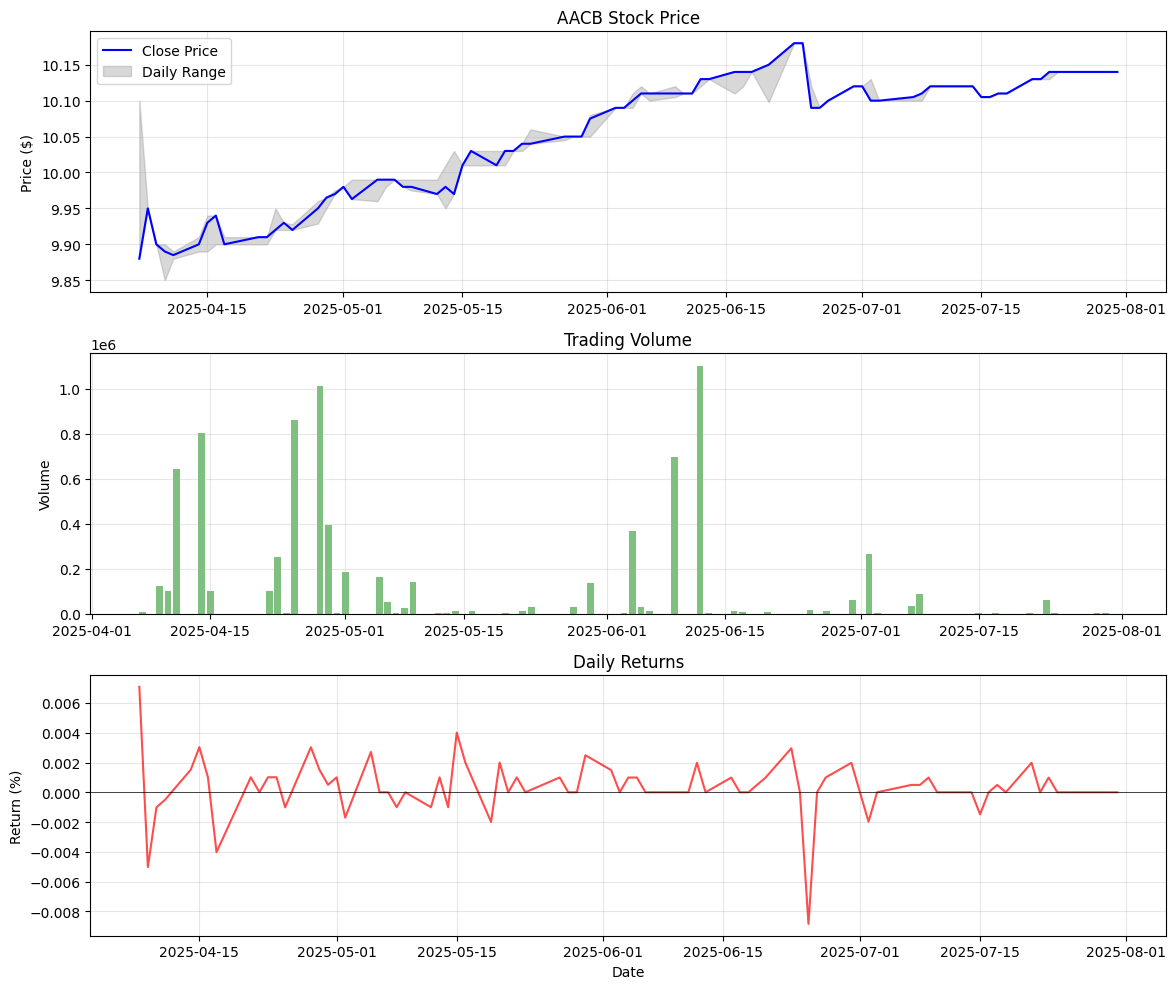

In [10]:
# Cell 7: Visualize Sample Data
import matplotlib.pyplot as plt

# Pick first stock for visualization
symbol = list(stock_data.keys())[0]
df = stock_data[symbol]

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Plot 1: Price
axes[0].plot(df.index, df['close'], label='Close Price', color='blue')
axes[0].fill_between(df.index, df['low'], df['high'], alpha=0.3, color='gray', label='Daily Range')
axes[0].set_title(f'{symbol} Stock Price')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Volume
axes[1].bar(df.index, df['volume'], color='green', alpha=0.5)
axes[1].set_title('Trading Volume')
axes[1].set_ylabel('Volume')
axes[1].grid(True, alpha=0.3)

# Plot 3: Returns
returns = df['close'].pct_change()
axes[2].plot(df.index, returns, color='red', alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].set_title('Daily Returns')
axes[2].set_ylabel('Return (%)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Cell 8: Get Reference Data
def get_reference_data(symbols):
    """Get reference data for symbols."""
    
    ref_data = []
    
    for symbol in symbols:
        print(f"Getting info for {symbol}...")
        ticker = yf.Ticker(symbol)
        info = ticker.info
        
        ref_data.append({
            'symbol': symbol,
            'name': info.get('longName', 'N/A'),
            'sector': info.get('sector', 'N/A'),
            'industry': info.get('industry', 'N/A'),
            'market_cap': info.get('marketCap', 0),
            'exchange': info.get('exchange', 'N/A'),
            'currency': info.get('currency', 'USD'),
            'employees': info.get('fullTimeEmployees', 0),
            'description': info.get('longBusinessSummary', 'N/A')[:200] + '...' if info.get('longBusinessSummary') else 'N/A'
        })
    
    return pd.DataFrame(ref_data)

# Get reference data
ref_df = get_reference_data(test_symbols)
print("\nReference Data:")
print(ref_df[['symbol', 'name', 'sector', 'market_cap']].to_string())

Getting info for AACB...
Getting info for AACG...
Getting info for AACI...
Getting info for AAL...
Getting info for AAME...
Getting info for AAOI...
Getting info for AAON...
Getting info for AAPG...
Getting info for AAPL...
Getting info for AARD...

Reference Data:
  symbol                           name              sector     market_cap
0   AACB     Artius II Acquisition Inc.  Financial Services      297822016
1   AACG          ATA Creativity Global  Consumer Defensive       58220704
2   AACI    Armada Acquisition Corp. II                 N/A      396278784
3    AAL   American Airlines Group Inc.         Industrials     7640819712
4   AAME  Atlantic American Corporation  Financial Services       45893700
5   AAOI  Applied Optoelectronics, Inc.          Technology     1300700288
6   AAON                     AAON, Inc.         Industrials     5864461312
7   AAPG                            N/A          Healthcare     3732468736
8   AAPL                     Apple Inc.          Technology

In [12]:
# Cell 9: Save Processed Data as Parquet with Smart Partitioning
def save_data_parquet(stock_data, ref_data, output_dir="data/processed"):
    """Save processed data as Parquet with smart partitioning."""
    
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Strategy 1: Save individual stock data (only for frequently accessed stocks)
    # For the most important stocks, keep individual files
    important_symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "SPY"]
    
    for symbol, df in stock_data.items():
        if symbol in important_symbols:
            file_path = output_path / "individual" / f"{symbol}.parquet"
            file_path.parent.mkdir(exist_ok=True)
            df.to_parquet(file_path, compression='snappy')
            print(f"Saved {symbol} to individual file")
    
    # Strategy 2: Combine data by sector/exchange for efficient storage
    # First, enrich with reference data
    combined_data = []
    
    for symbol, df in stock_data.items():
        df_copy = df.copy()
        df_copy['symbol'] = symbol
        
        # Add reference data if available
        if symbol in ref_data['symbol'].values:
            ref_row = ref_data[ref_data['symbol'] == symbol].iloc[0]
            df_copy['sector'] = ref_row.get('sector', 'Unknown')
            df_copy['industry'] = ref_row.get('industry', 'Unknown')
            df_copy['market_cap'] = ref_row.get('market_cap', 0)
        else:
            df_copy['sector'] = 'Unknown'
            df_copy['industry'] = 'Unknown'
            df_copy['market_cap'] = 0
        
        combined_data.append(df_copy)
    
    # Combine all data
    all_data = pd.concat(combined_data, ignore_index=False)
    
    # Strategy 3: Partition by year and sector for balanced file sizes
    all_data['year'] = pd.to_datetime(all_data.index).year
    
    # Save partitioned data
    partitions_path = output_path / "partitioned"
    partitions_path.mkdir(exist_ok=True)
    
    # Group by year and sector
    for (year, sector), group in all_data.groupby(['year', 'sector']):
        # Clean sector name for filename
        sector_clean = sector.replace('/', '_').replace(' ', '_')
        partition_file = partitions_path / f"year={year}" / f"sector={sector_clean}" / "data.parquet"
        partition_file.parent.mkdir(parents=True, exist_ok=True)
        
        # Drop the year column before saving (it's in the partition)
        group_save = group.drop(columns=['year'])
        group_save.to_parquet(partition_file, compression='snappy')
        print(f"Saved partition: year={year}, sector={sector_clean} ({len(group)} rows)")
    
    # Strategy 4: Save a single consolidated file for quick access (all data)
    consolidated_file = output_path / "all_stocks_consolidated.parquet"
    all_data.drop(columns=['year']).to_parquet(consolidated_file, compression='snappy')
    print(f"\nSaved consolidated file with {len(all_data)} total rows")
    
    # Save reference data
    ref_path = output_path / "reference_data.parquet"
    ref_data.to_parquet(ref_path, compression='snappy')
    print(f"Saved reference data to {ref_path}")
    
    # Create a metadata file with summary information
    metadata = {
        'symbols': list(stock_data.keys()),
        'date_range': {
            'start': str(all_data.index.min()),
            'end': str(all_data.index.max())
        },
        'total_rows': len(all_data),
        'sectors': all_data['sector'].unique().tolist(),
        'file_structure': {
            'individual': 'Important stocks saved individually in individual/',
            'partitioned': 'All data partitioned by year and sector in partitioned/',
            'consolidated': 'All data in single file: all_stocks_consolidated.parquet'
        }
    }
    
    import json
    metadata_path = output_path / "metadata.json"
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"\nSaved metadata to {metadata_path}")
    
    # Print summary statistics
    print("\n" + "="*60)
    print("STORAGE SUMMARY")
    print("="*60)
    
    # Calculate file sizes
    total_size = 0
    for file in output_path.rglob("*.parquet"):
        size_mb = file.stat().st_size / (1024 * 1024)
        total_size += size_mb
        if size_mb > 1:  # Only show files > 1MB
            print(f"  {file.relative_to(output_path)}: {size_mb:.2f} MB")
    
    print(f"\nTotal storage used: {total_size:.2f} MB")
    
    # Compare with CSV size (approximate)
    csv_size_estimate = len(all_data) * 100 / (1024 * 1024)  # ~100 bytes per row
    print(f"Estimated CSV size would be: {csv_size_estimate:.2f} MB")
    print(f"Compression ratio: {csv_size_estimate/total_size:.1f}x")
    
    return all_data

# Save the data using new Parquet format
all_data = save_data_parquet(stock_data, ref_df)

Saved AAPL to individual file
Saved AMZN to individual file
Saved GOOGL to individual file
Saved MSFT to individual file
Saved TSLA to individual file
Saved partition: year=2001, sector=Financial_Services (248 rows)
Saved partition: year=2001, sector=Industrials (248 rows)
Saved partition: year=2001, sector=Technology (248 rows)
Saved partition: year=2001, sector=Unknown (418451 rows)
Saved partition: year=2002, sector=Financial_Services (252 rows)
Saved partition: year=2002, sector=Industrials (252 rows)
Saved partition: year=2002, sector=Technology (252 rows)
Saved partition: year=2002, sector=Unknown (442625 rows)
Saved partition: year=2003, sector=Financial_Services (252 rows)
Saved partition: year=2003, sector=Industrials (252 rows)
Saved partition: year=2003, sector=Technology (252 rows)
Saved partition: year=2003, sector=Unknown (463252 rows)
Saved partition: year=2004, sector=Financial_Services (252 rows)
Saved partition: year=2004, sector=Industrials (252 rows)
Saved partition

In [14]:
# Cell 10: Efficient Data Loading Functions
def load_parquet_data(output_dir="data/processed"):
    """Demonstrate different ways to load the saved Parquet data."""
    
    output_path = Path(output_dir)
    
    print("Loading data examples:")
    print("="*50)
    
    # Method 1: Load single stock (if saved individually)
    individual_path = output_path / "individual" / "AAPL.parquet"
    if individual_path.exists():
        aapl_df = pd.read_parquet(individual_path)
        print(f"✓ Loaded AAPL individually: {len(aapl_df)} rows")
    
    # Method 2: Load all data at once
    consolidated_path = output_path / "all_stocks_consolidated.parquet"
    if consolidated_path.exists():
        all_df = pd.read_parquet(consolidated_path)
        print(f"✓ Loaded consolidated data: {len(all_df)} rows")
        print(f"  Symbols: {all_df['symbol'].nunique()}")
        print(f"  Date range: {all_df.index.min()} to {all_df.index.max()}")
    
    # Method 3: Load specific partition (e.g., Tech stocks from 2023)
    partition_path = output_path / "partitioned" / "year=2023" / "sector=Technology"
    if partition_path.exists():
        tech_2023 = pd.read_parquet(partition_path)
        print(f"✓ Loaded Tech 2023 partition: {len(tech_2023)} rows")
        print(f"  Symbols: {tech_2023['symbol'].unique()}")
    
    # Method 4: Load reference data
    ref_path = output_path / "reference_data.parquet"
    if ref_path.exists():
        ref_df = pd.read_parquet(ref_path)
        print(f"✓ Loaded reference data: {len(ref_df)} companies")
    
    # Method 5: Use pandas to read partitioned dataset
    partitioned_path = output_path / "partitioned"
    if partitioned_path.exists():
        # This reads all partitions automatically
        partitioned_df = pd.read_parquet(partitioned_path, engine='pyarrow')
        print(f"✓ Loaded all partitions: {len(partitioned_df)} rows")
    
    print("\n💡 Tip: Parquet files are ~3-5x smaller than CSV and load ~5-10x faster!")
    
    return all_df if consolidated_path.exists() else None

# Test loading
loaded_data = load_parquet_data()

Loading data examples:
✓ Loaded AAPL individually: 6181 rows
✓ Loaded consolidated data: 19013648 rows
  Symbols: 5665
  Date range: 2001-01-02 00:00:00-05:00 to 2025-07-31 00:00:00-04:00
✓ Loaded Tech 2023 partition: 500 rows
  Symbols: ['AAOI' 'AAPL']
✓ Loaded reference data: 10 companies


ArrowTypeError: Unable to merge: Field sector has incompatible types: string vs dictionary<values=string, indices=int32, ordered=0>

In [16]:
# Cell 11: Prepare for Next Stage - Batch Fetch with Progress Bar
from tqdm.notebook import tqdm
import time

def batch_fetch_stocks(symbols, start_date, end_date, batch_size=10):
    """Fetch stocks in batches with progress tracking."""
    
    fetcher = SimpleDataFetcher()
    all_data = {}
    failed_symbols = []
    
    # Create progress bar
    with tqdm(total=len(symbols), desc="Fetching stocks") as pbar:
        for i in range(0, len(symbols), batch_size):
            batch = symbols[i:i+batch_size]
            
            for symbol in batch:
                try:
                    df = fetcher.fetch_single_stock(symbol, start_date, end_date)
                    if df is not None and not df.empty:
                        all_data[symbol] = df
                    else:
                        failed_symbols.append(symbol)
                except Exception as e:
                    print(f"\n⚠️ Error fetching {symbol}: {e}")
                    failed_symbols.append(symbol)
                
                pbar.update(1)
                time.sleep(0.1)  # Be nice to Yahoo Finance
    
    print(f"\n✓ Successfully fetched {len(all_data)}/{len(symbols)} stocks")
    if failed_symbols:
        print(f"⚠️ Failed symbols: {failed_symbols}")
    
    return all_data

# Uncomment to fetch more symbols for a broader universe

# # Extended symbol list (top S&P 500 components)
# extended_symbols = [
#     "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "BRK-B",
#     "JPM", "JNJ", "V", "PG", "UNH", "HD", "MA", "DIS", "BAC", "XOM",
#     "PFE", "KO", "PEP", "TMO", "CSCO", "ABT", "CVX", "WMT", "CRM", "MRK",
#     "LLY", "ADBE", "NKE", "ORCL", "ACN", "COST", "AVGO", "MCD", "TXN", "DHR"
# ]
# 
# # Fetch extended data with progress bar
# extended_data = batch_fetch_stocks(extended_symbols, start_date, end_date)
# 
# # Get reference data for successfully fetched symbols
# extended_ref = get_reference_data(list(extended_data.keys()))
# 
# # Save using Parquet format
# save_data_parquet(extended_data, extended_ref)

In [17]:
# Cell 12: Summary and Next Steps
print("=" * 60)
print("STAGE 1: DATA RETRIEVAL - COMPLETE")
print("=" * 60)
print(f"\n✓ Fetched data for {len(stock_data)} stocks")
print(f"✓ Date range: {start_date} to {end_date}")
print(f"✓ Data saved to: data/processed/")
print(f"✓ Quality checks performed")
print(f"✓ Reference data collected")

print("\n📊 Summary Statistics:")
print(f"  Average daily volume: ${stats_df['avg_dollar_volume'].mean()/1e6:.1f}M")
print(f"  Average volatility: {stats_df['volatility'].mean():.1%}")
print(f"  Best performer: {stats_df.loc[stats_df['total_return'].idxmax(), 'symbol']} "
      f"({stats_df['total_return'].max():.1f}%)")

print("\n🚀 Ready for Stage 2: Coarse Filtering")
print("  Next: Apply rule-based filters to select universe")

STAGE 1: DATA RETRIEVAL - COMPLETE

✓ Fetched data for 5665 stocks
✓ Date range: 2001-01-01 to 2025-08-01
✓ Data saved to: data/processed/
✓ Quality checks performed
✓ Reference data collected

📊 Summary Statistics:
  Average daily volume: $41.2M
  Average volatility: 134.9%
  Best performer: DEC (3863678.1%)

🚀 Ready for Stage 2: Coarse Filtering
  Next: Apply rule-based filters to select universe
